# 0.0 Imports

In [1]:
import math
import json
import numpy as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import datetime
import seaborn as sns
import xgboost as xgb
from tabulate import tabulate
import os

from scipy import stats as ss
from boruta import BorutaPy
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


## 0.1 Helper functions

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    """
    function to perform croos_valuation iterations and return MAE, MAPE and RMSE avg and std values of all iterations performed.
    Parameters:
        *x_training*: the data to fit. Complete data with the response variable and the date column.
        *kfold*: int, number of iterations/validations you want to perform.
        *model_name*: str, name for the model, will be used on the final table with the results.
        *model*: estimator object implementing ‘fit’. The object to use to fit the data. 
         As a suggestion, write the algorithm and parameters, save it in a variable and here just enter the variable.
        *verbose*: default=False, if True the algorithm will print which iteration it is in.
    Returns: a dataframe with median and standard deviation of the MAE, MAPE and RMSE metrics.
    
    """    
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']
        # model
        m = model.fit( xtraining, ytraining )
        # prediction
        yhat = m.predict( xvalidation )
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat ) )
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
    return pd.DataFrame( {'Model Name': model_name,
    'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round( np.std( mae_list 
                                                                            ), 2 ).astype( str ),
    'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list 
                                                                            ), 2 ).astype( str ),
    'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list 
                                                                             ), 2 ).astype( str )}, index=[0] )

def mean_absolute_percentage_error( y, yhat ):
    """
    function to calculate the mean absolute percentage error from the predictions of a regression algorithm
    Parameters:
        *y*:the data column with the real results.
        *yhat*: the data column with the predictions.
    Returns: the MAPE result.
    """
    
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    """
    function to calculate the MAE, MAPE and RMSE values from the predictions of a regression algorithm.
    Parameters:
        *model_name: str, name for the model, will be used on the final dataframe with the results.
        *y*:the data column with the real results.
        *yhat*: the data column with the predictions.
    Returns:a dataframe with the MAE, MAPE and RMSE results.
    """
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( { 'Model Name': model_name,
    'MAE': mae,
    'MAPE': mape,
    'RMSE': rmse }, index=[0] )


def cramer_v( x, y ):
    """
    function to calculate the cramer_v, a measure of association between two nominal variables.
    Parameters:
        *x: the data column with the nominal variable 1.
        *y*:the data column with the nominal variable 2.
    Returns: the cramer_v result.
    """
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )
def jupyter_settings():
    """
    function to configure jupyter settings and views.
    
    """
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [3]:
jupyter_settings()

## 0.2 Loading data

In [4]:
df_sales_raw = pd.read_csv('data\\train.csv', low_memory=False)
df_store_raw = pd.read_csv('data\\store.csv', low_memory=False)
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')
df_raw

# 1.0 Descrição dos dados

In [5]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )
cols_new = list (map(snakecase, cols_old))
df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print (f'Number of Rows: {df1.shape[0]}')
print (f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NAs

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x:200000.0 if math.isnan( x ) else x )
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else
x['competition_open_since_year'], axis=1 )
#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )
#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True )
df1['month_map'] = df1['date'].dt.month.map( month_map )
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Data Types

In [12]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int )
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7 Descriptive statistic

In [13]:
# separation of numeric and categorical attributes
num_attributes = df1.select_dtypes( include=['int64', 'int32', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'int32', 'float64','datetime64[ns]'] )

##  1.7.1. Numerical Atributes

In [14]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T
# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<Axes: xlabel='competition_distance', ylabel='Count'>

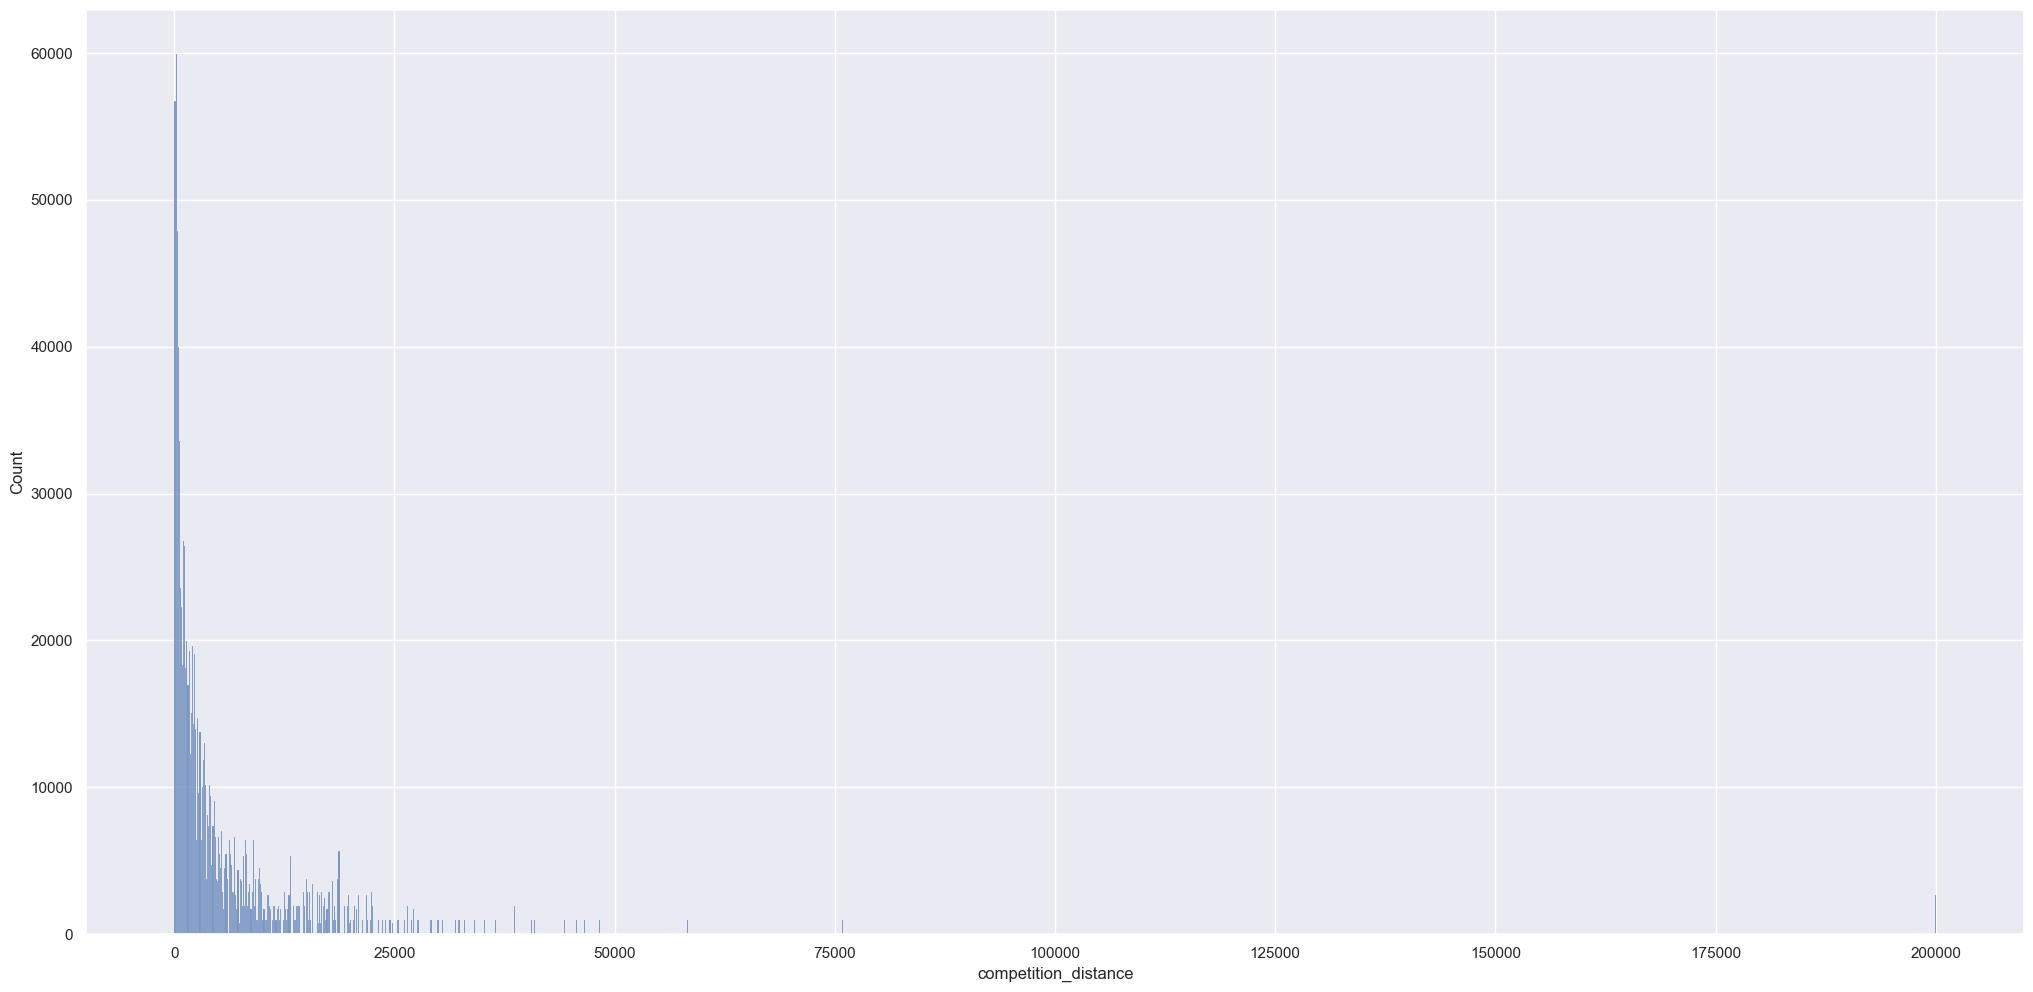

In [15]:
sns.histplot( df1['competition_distance'], kde=False )

##  1.7.2. Categorical Atributes

In [16]:
 cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

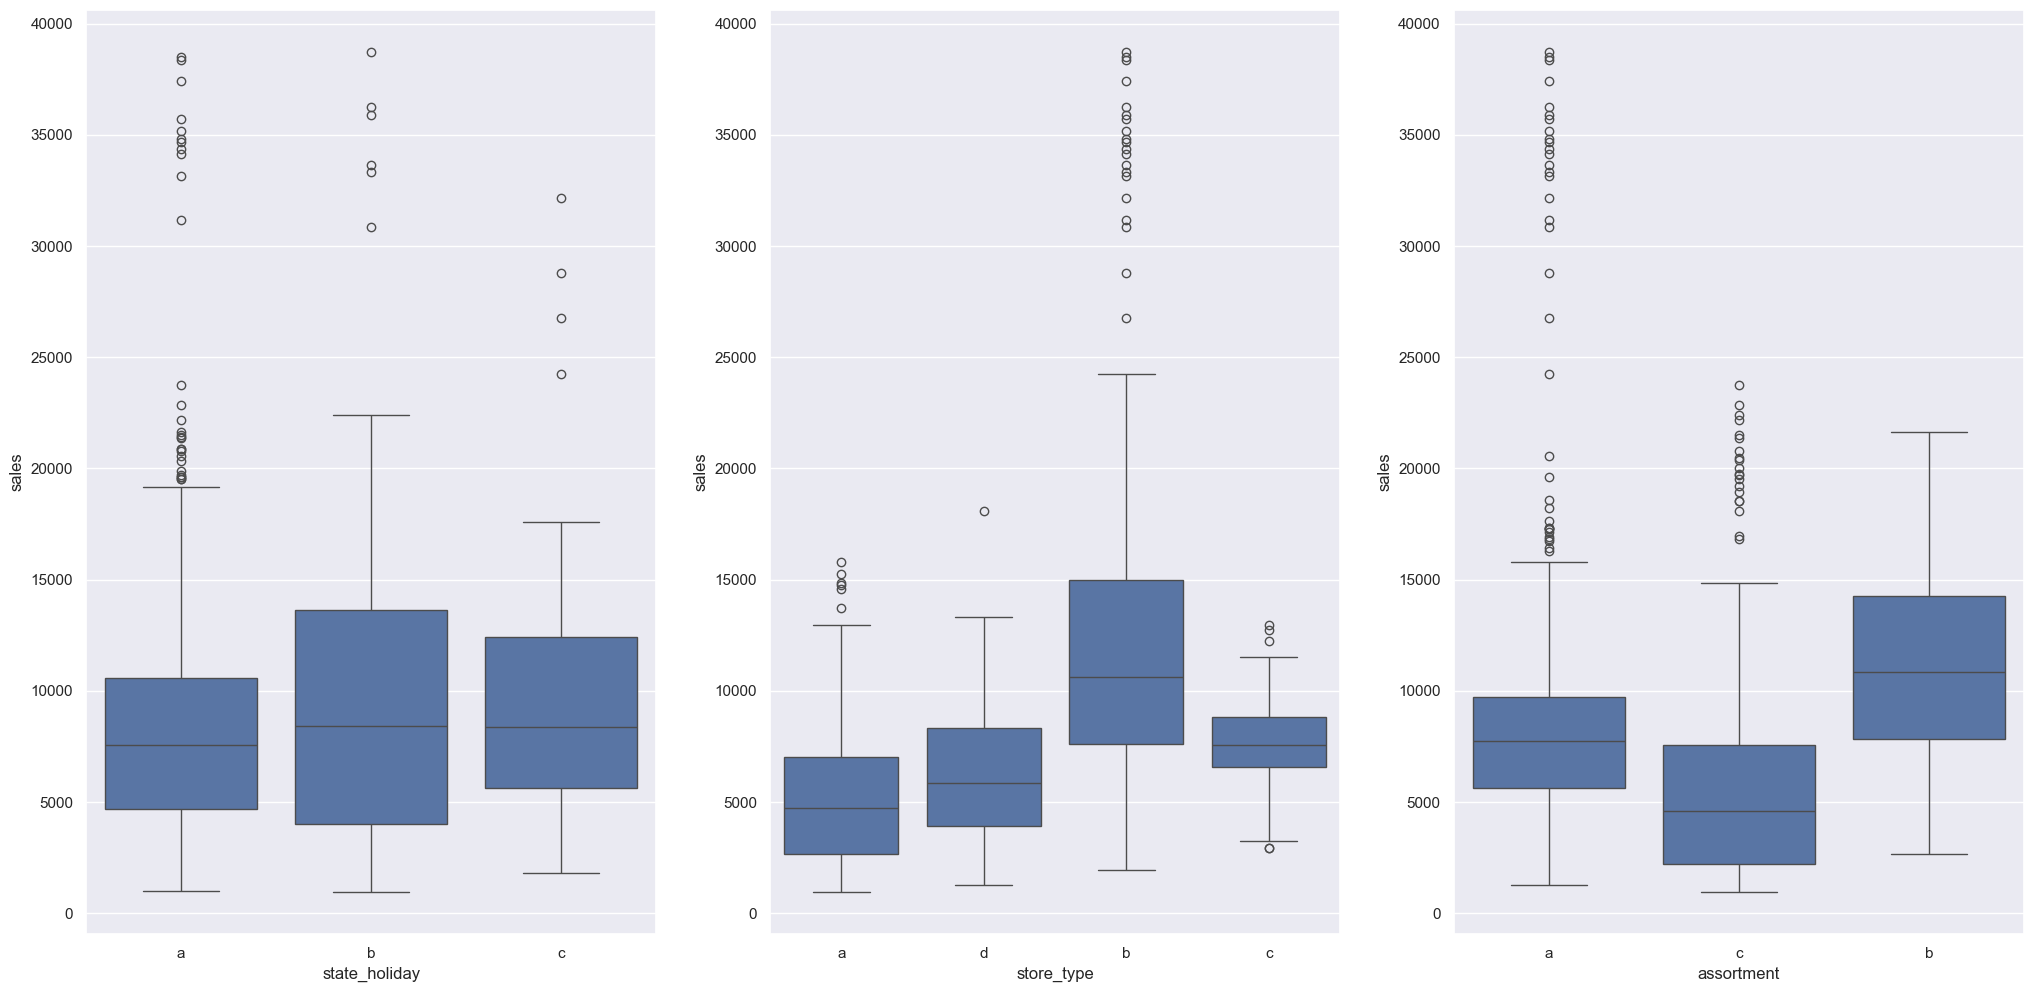

In [17]:
# attribute behavior in relation to the response variable
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )
plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )
plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

#  2.0. PASSO 02 - FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

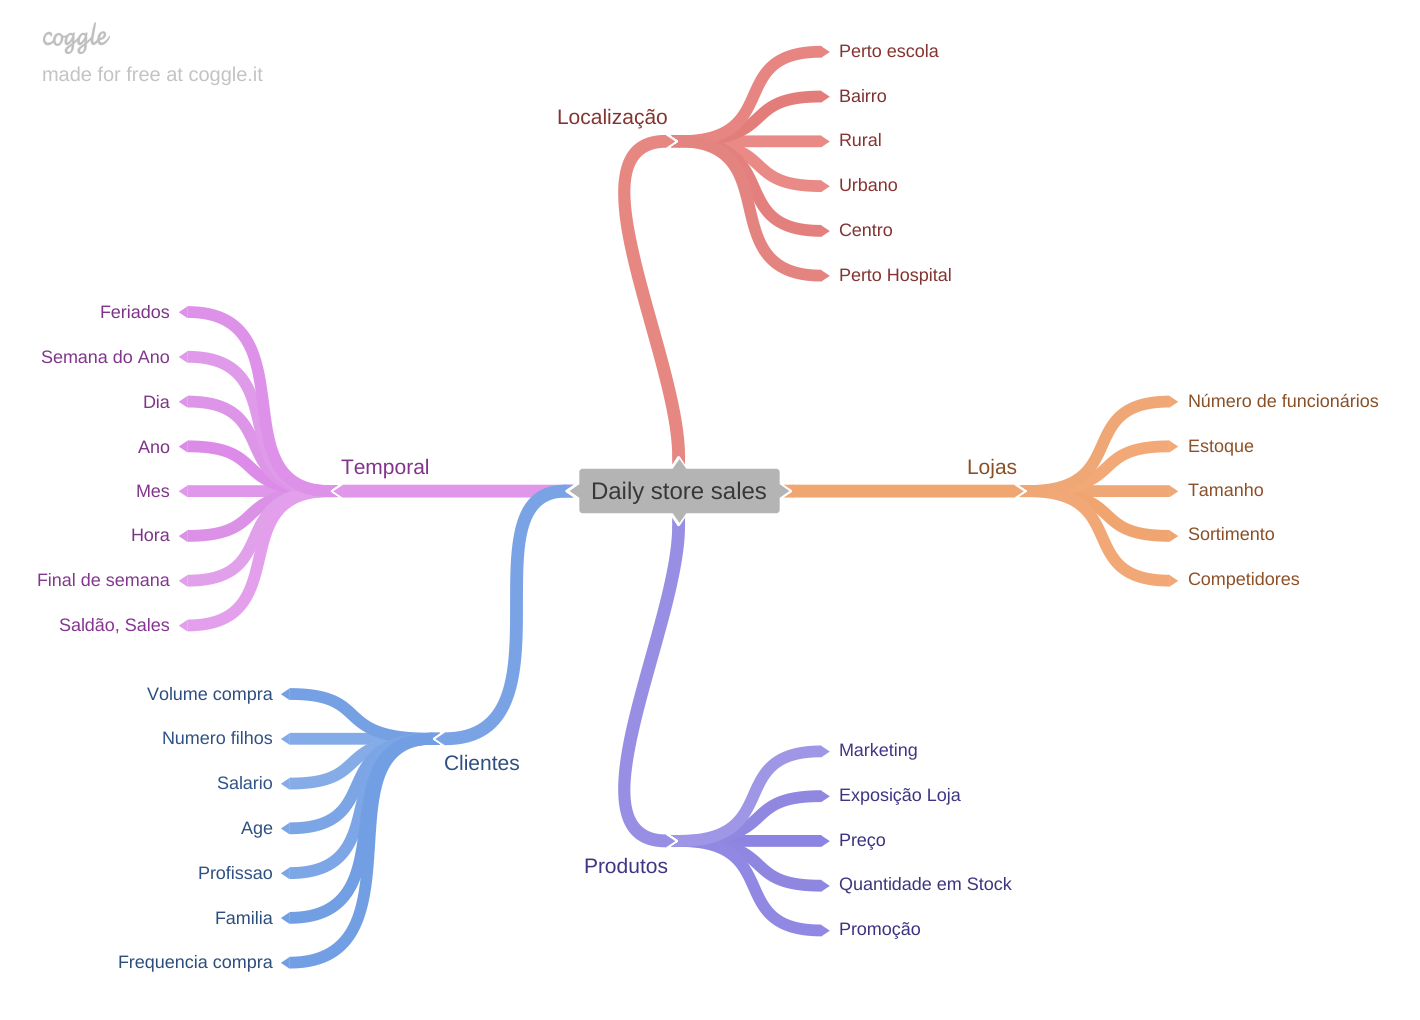

In [19]:
Image( 'img\\daily_store_sales.png' )

## 2.2. Criacao das Hipoteses

### 2.2.1. Hipoteses Loja

####
1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipoteses Produto

####
1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.2. Hipoteses Tempo

####
1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

### 2.3. Lista Final de Hipóteses

####
1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais promoções consecutivas deveriam vender mais.
6. Lojas abertas durante o feriado de Natal deveriam vender mais.
7. Lojas deveriam vender mais ao longo dos anos.
8. Lojas deveriam vender mais no segundo semestre do ano.
9. Lojas deveriam vender mais depois do dia 10 de cada mês.
10. Lojas deveriam vender menos aos finais de semana.
11. Lojas deveriam vender menos durante os feriados escolares.

### 2.4. Feature Engineering

In [20]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )
# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                  month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )
# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [21]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [22]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Selecao das Colunas

In [23]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

 # 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [24]:
df4 = df3.copy()

 ## 4.1. Analise Univariada

### 4.1.1. Response Variable

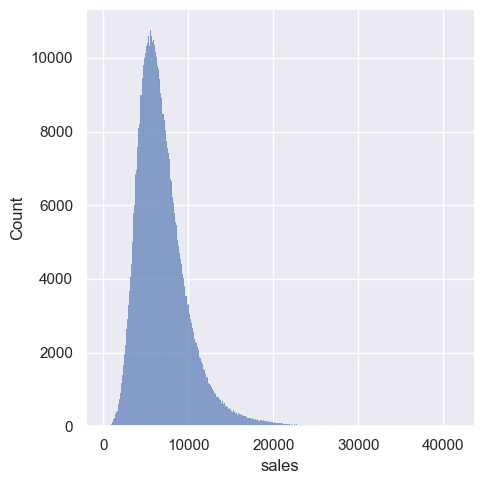

In [25]:
sns.displot( df4['sales'], kde=False )

### 4.1.2. Numerical Variable

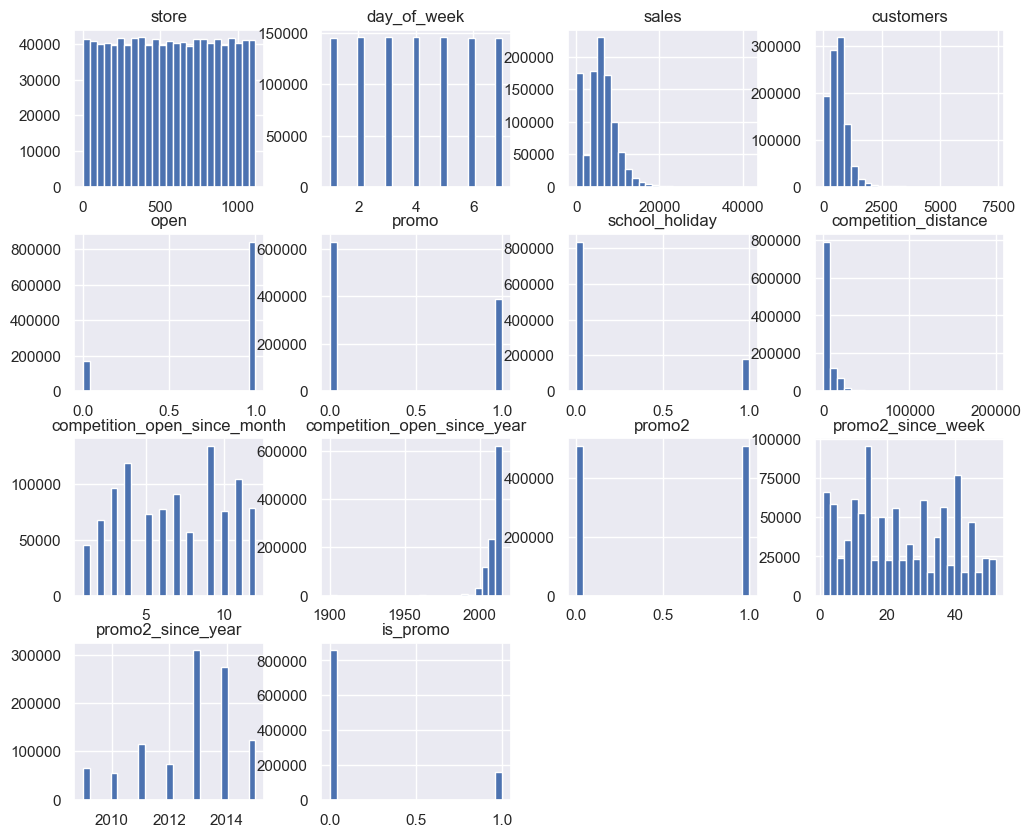

In [26]:
num_attributes.hist( bins=25, histtype='barstacked', figsize=(12, 10));

###  4.1.3. Categorical Variable

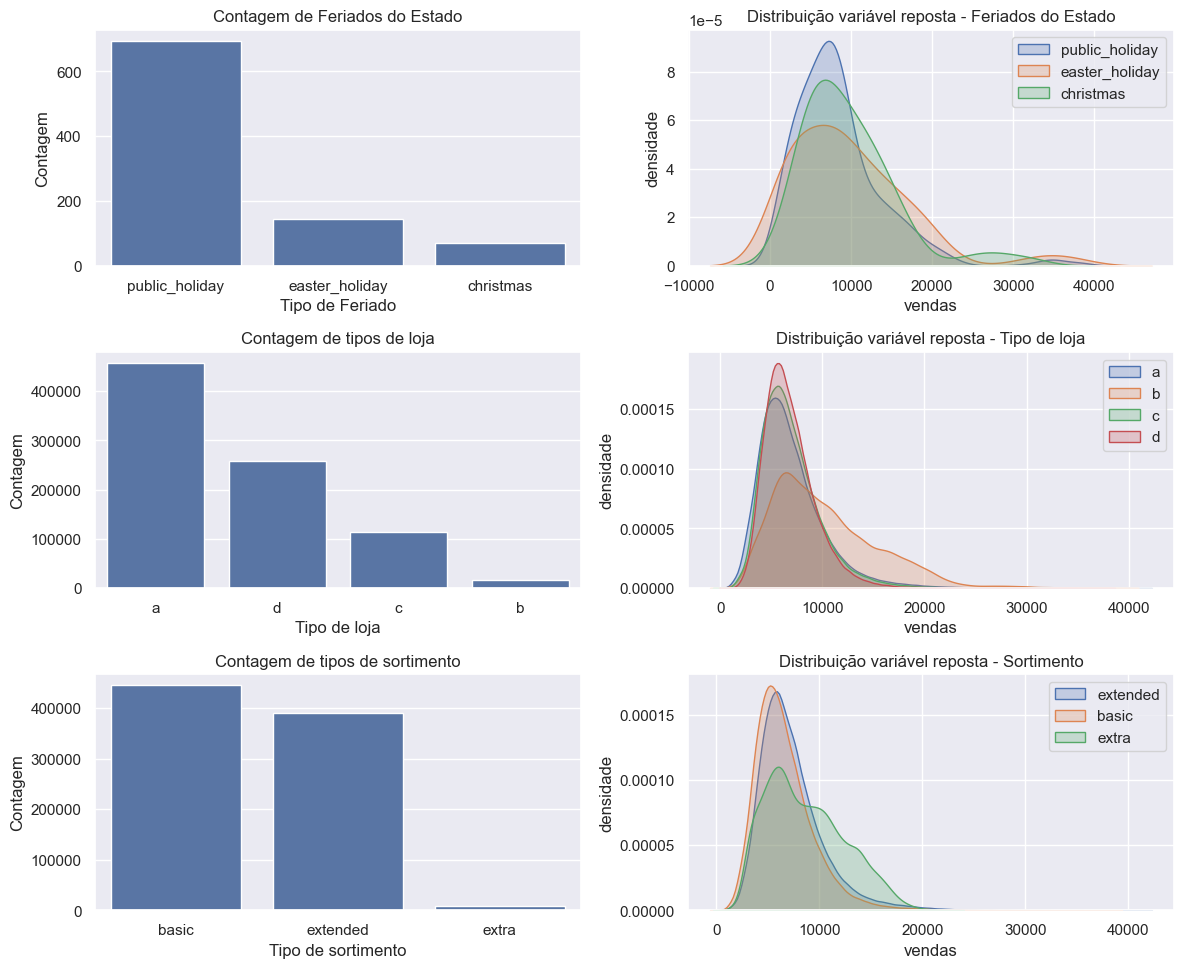

In [27]:
# state_holiday
plt.figure(figsize=(12, 10))
plt.subplot( 3, 2, 1 )
df_holiday = df4[df4['state_holiday'] != 'regular_day'].reset_index()
sns.countplot(x='state_holiday', data=df_holiday)
plt.title('Contagem de Feriados do Estado')
plt.xlabel('Tipo de Feriado')
plt.ylabel('Contagem')
plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)
plt.legend()
plt.title('Distribuição variável reposta - Feriados do Estado')
plt.xlabel('vendas')
plt.ylabel('densidade')

# store_type
plt.subplot( 3, 2, 3 )
# Conta os valores únicos na coluna 'store_type'
store_type_counts = df4['store_type'].value_counts()

# Cria o gráfico de barras com base nos valores contados
sns.barplot(x=store_type_counts.index, y=store_type_counts.values)
plt.title('Contagem de tipos de loja')
plt.xlabel('Tipo de loja')
plt.ylabel('Contagem')
plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True )
plt.legend()
plt.title('Distribuição variável reposta - Tipo de loja')
plt.xlabel('vendas')
plt.ylabel('densidade')
# assortment
plt.subplot( 3, 2, 5 )
#sns.countplot( df4['assortment'] )
assortment_count = df4['assortment'].value_counts()
sns.barplot(x=assortment_count.index, y=assortment_count.values)
plt.title('Contagem de tipos de sortimento')
plt.xlabel('Tipo de sortimento')
plt.ylabel('Contagem')
plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True )
plt.legend()
plt.title('Distribuição variável reposta - Sortimento')
plt.xlabel('vendas')
plt.ylabel('densidade')
plt.tight_layout()

## 4.2. Analise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais
Verdadeira, conforme o gráfico quanto maior o tipo de sortimento, maior é a média de vendas.

<Axes: xlabel='year_week'>

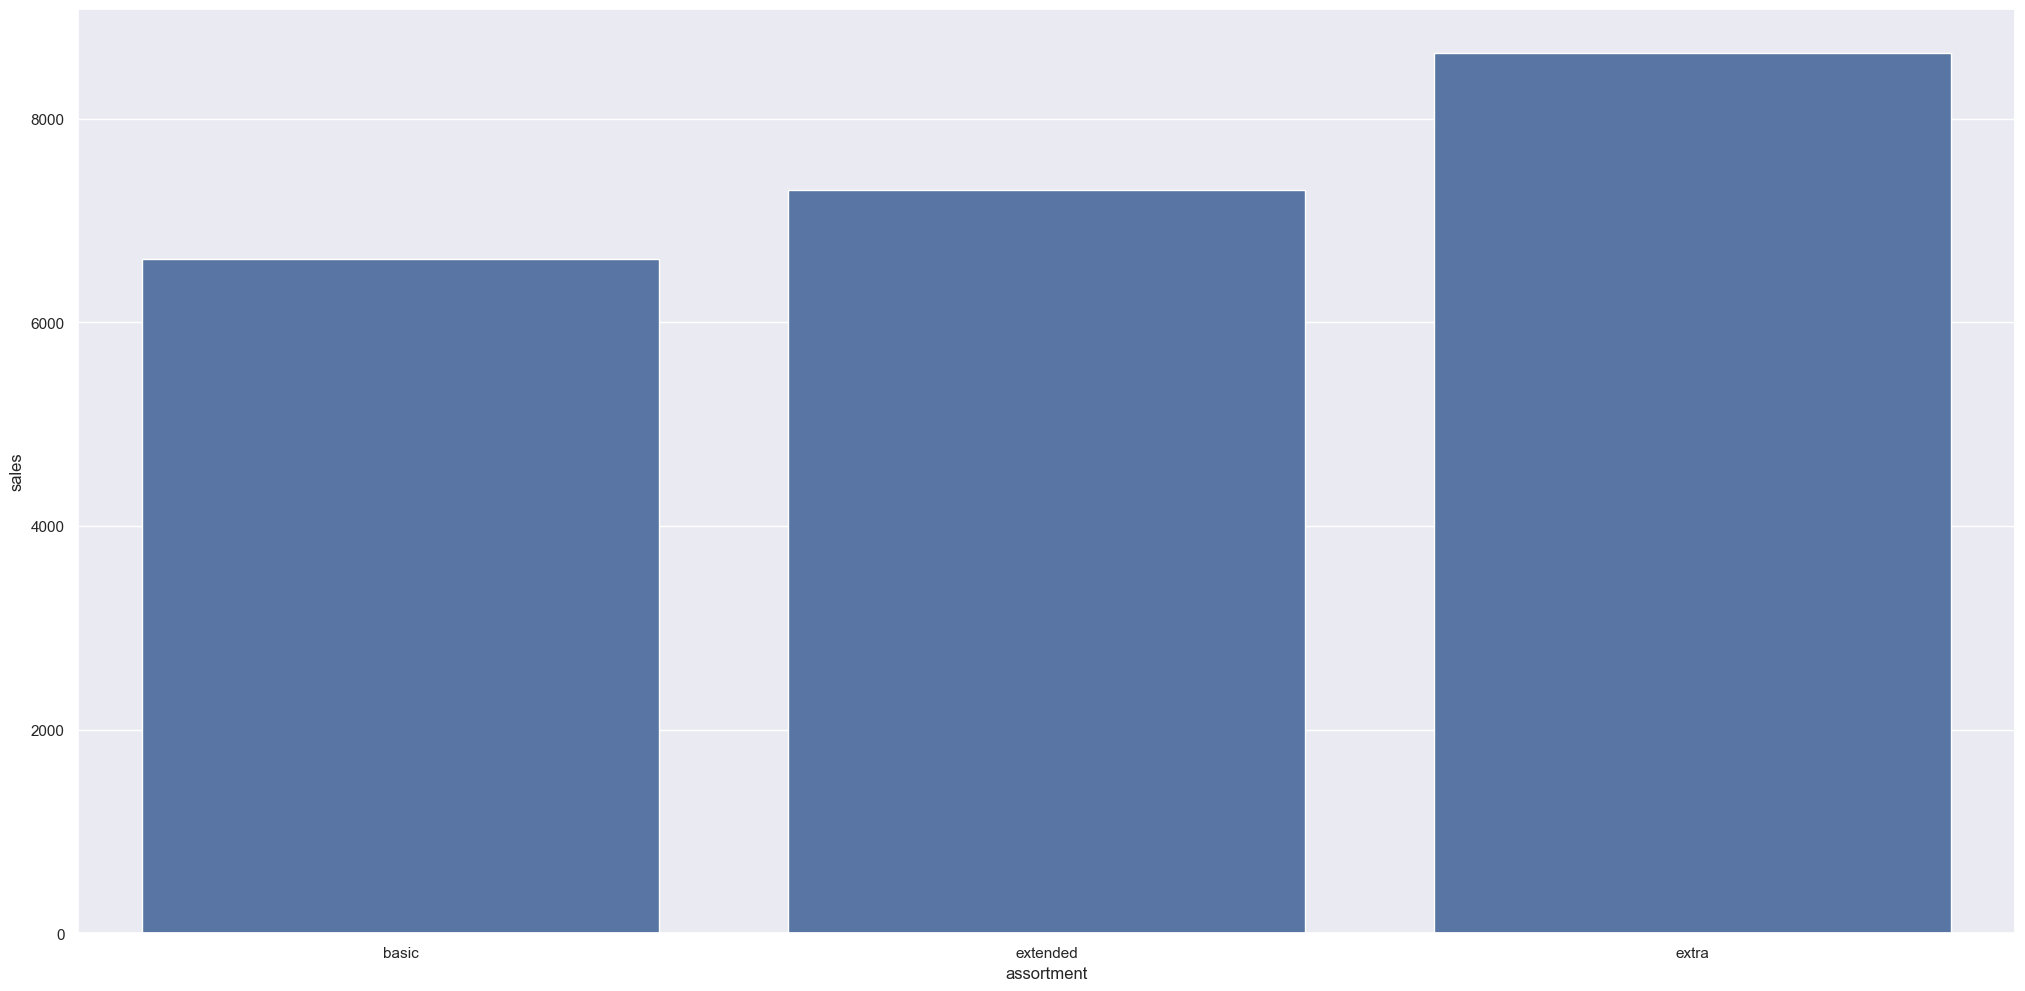

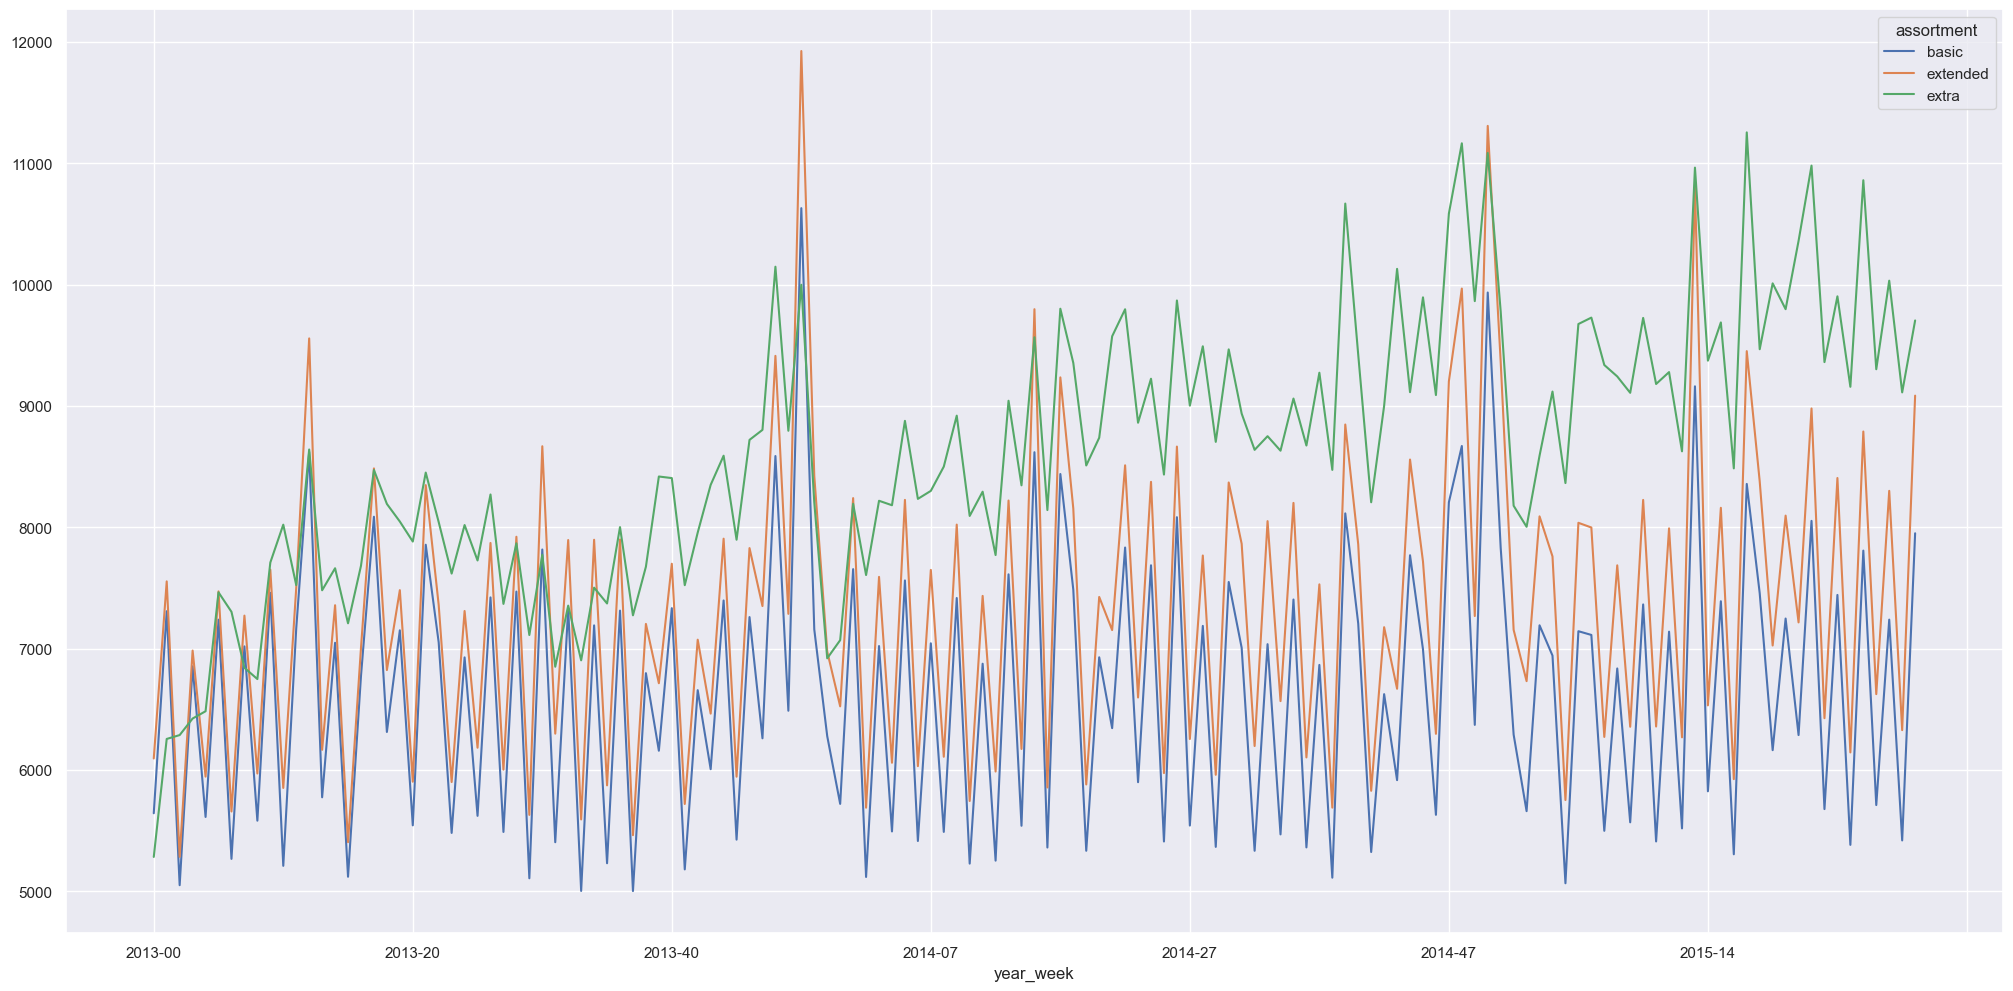

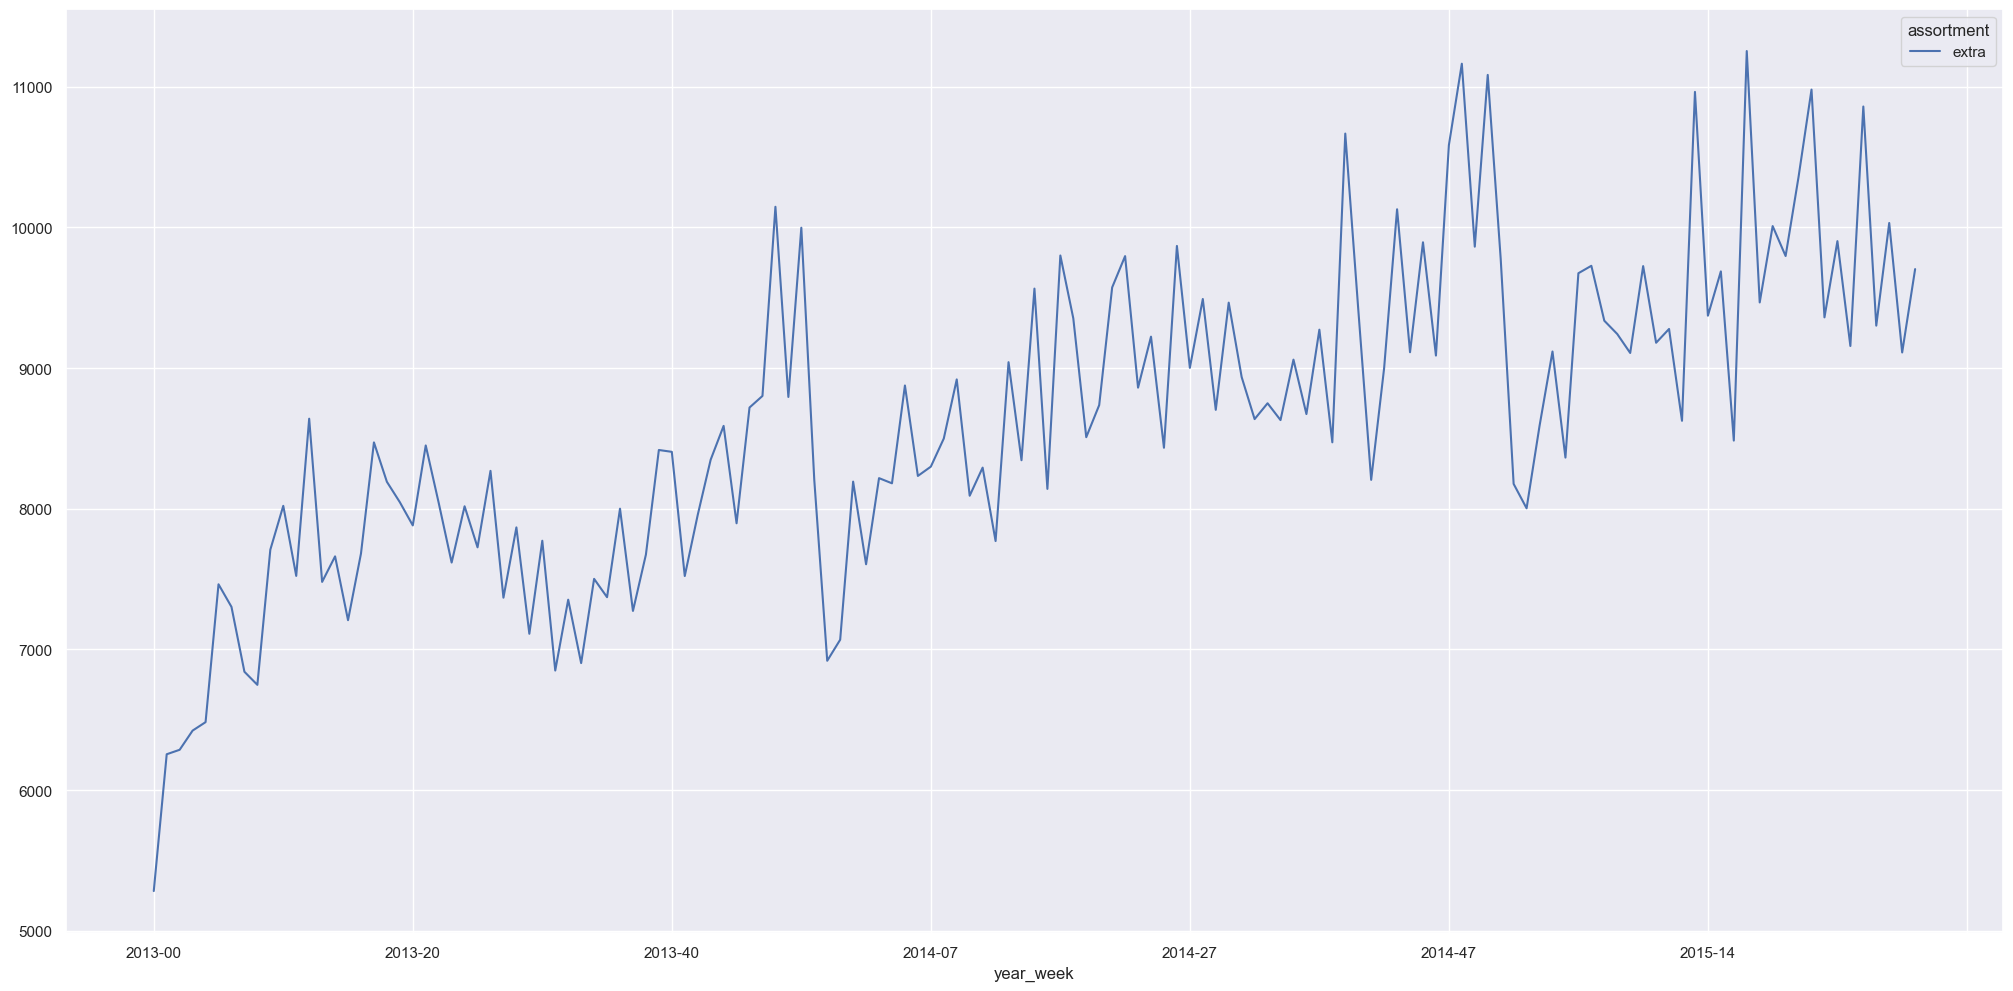

In [28]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).mean().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment'] ).mean().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()


### H2. Lojas com competidores mais próximos deveriam vender menos
Falso. Usando como parâmetro a média (pois o volume de lojas com competidores mais próximo é significativamente maior, dessa forma um parâmetro de soma não faria sentido), podemos observar que não existe uma significativa diferença na média de vendas em relação a distancia do competidor. Os maiores valores de média acabam se encontrando em lojas com competidores mais próximos, mas são poucos pontos, o que não seria o suficiente para afirmar o oposto (que lojas com competidores mais próximos vendem mais)

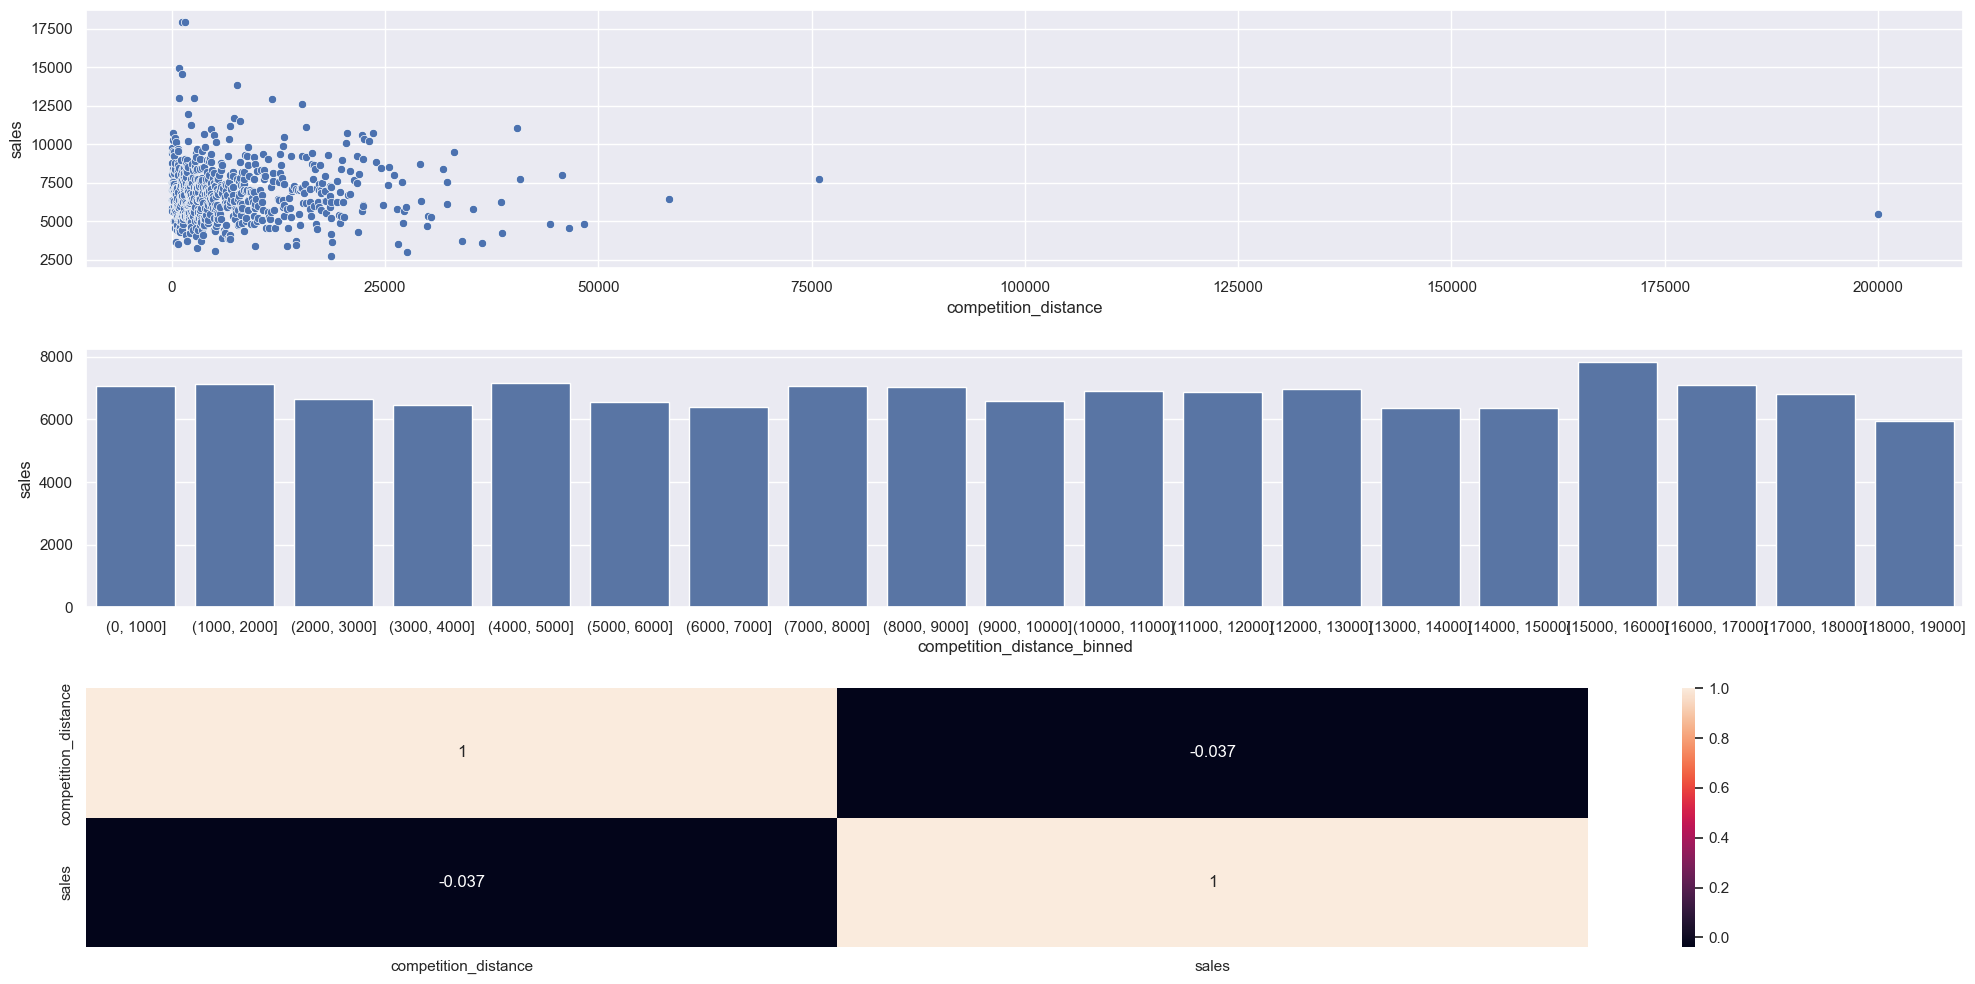

In [29]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()
plt.figure(figsize=(20, 10))
plt.subplot( 3, 1, 1 )
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot( 3, 1, 2 )
#como temos muitos dados, criamos bins para uma visualização mais concreta
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).mean().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 )

plt.subplot(3, 1, 3)
numeric_columns = aux1.select_dtypes(include=['number'])
x = sns.heatmap( numeric_columns.corr( method='pearson', numeric_only=False ), annot=True );
plt.tight_layout()

### H3. Lojas com competidores à mais tempo deveriam vender mais. 
Falso. Não conseguimos identificar um padrão de comportamento influênciado pela variável.Entretanto a correlação apresentada é alta.

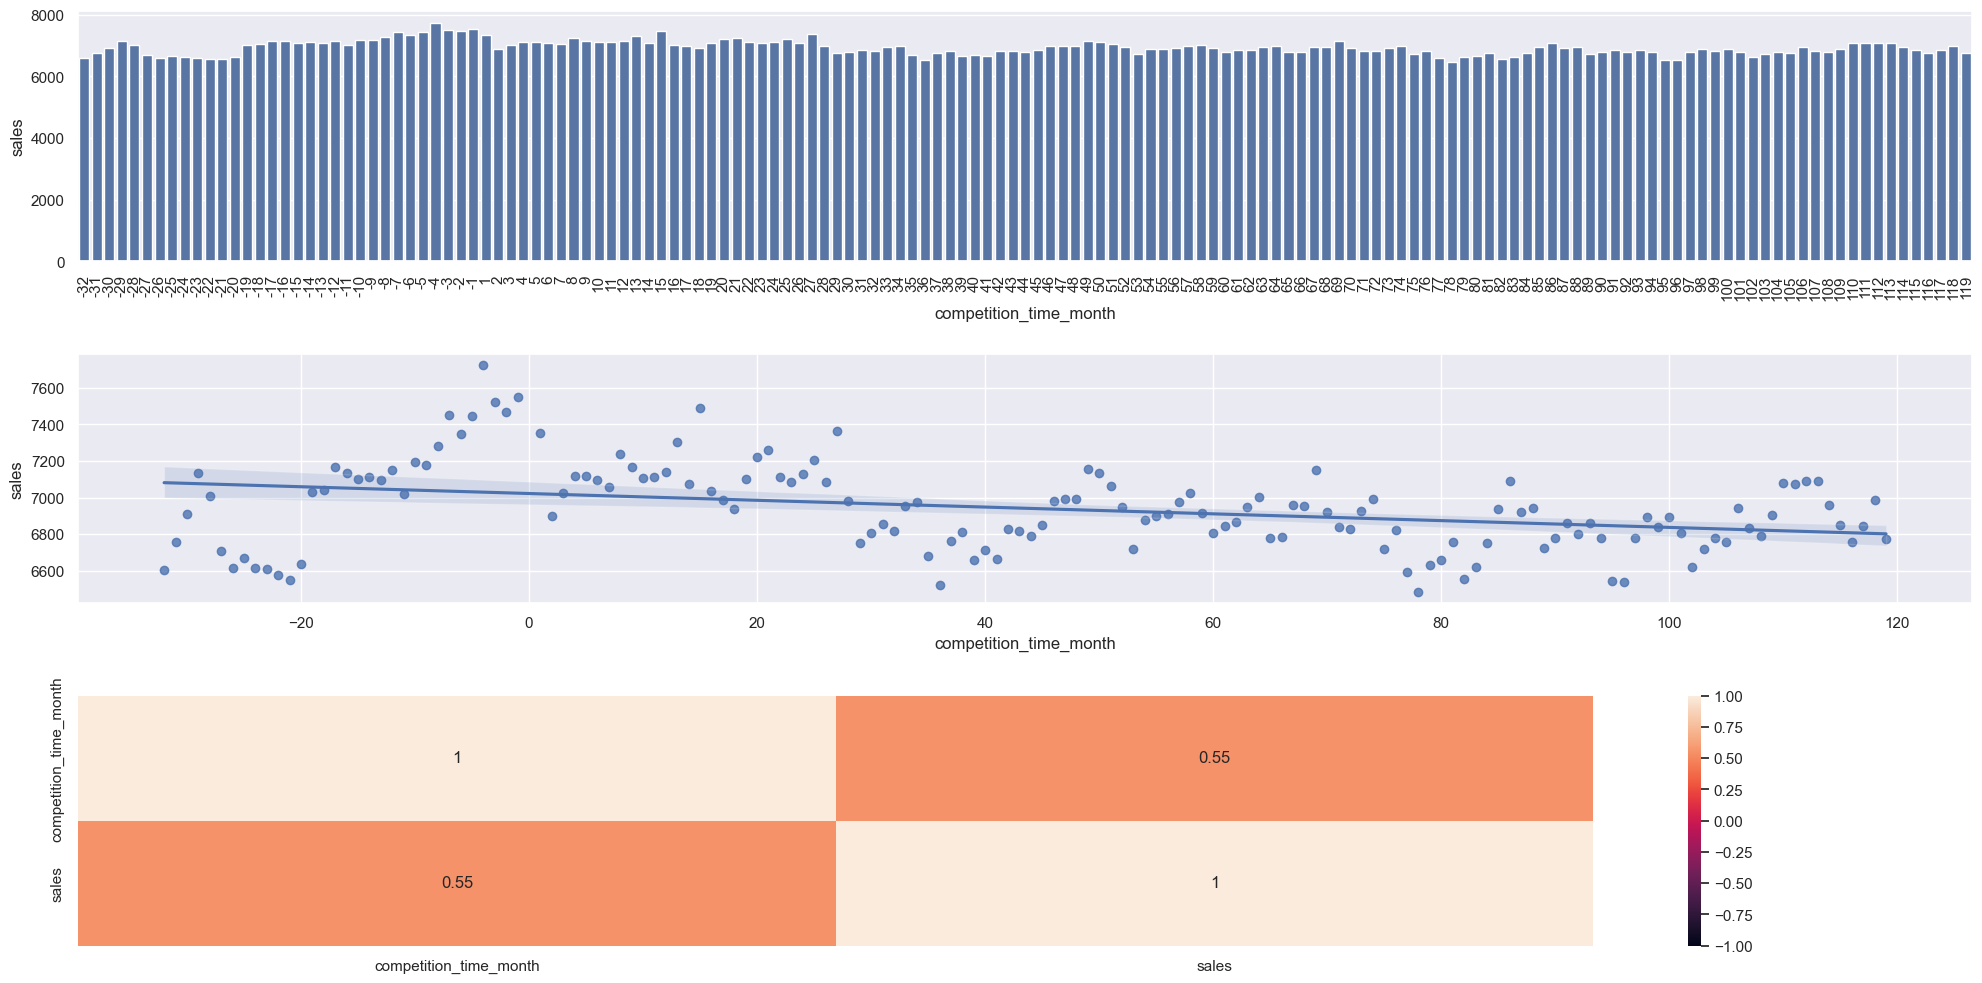

In [30]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
# como o gráfico levando em consideraçao todo o período ficou muito extenso e não é possível tirar grandes conclusões, filtramos parte do perído 
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
plt.figure(figsize=(20, 10))
plt.subplot( 3, 1, 1 )
sns.barplot( x='competition_time_month', y='sales', data=aux2 )
plt.xticks( rotation=90 );
plt.subplot( 3, 1, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );
plt.subplot( 3, 1, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True, vmin=-1, vmax=1  );

plt.tight_layout()

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
Verdadeiro. Ao juntar períodos mais longos de promoção, conseguimos observar uma curva de comportamento ascendente no gráfico de tendência

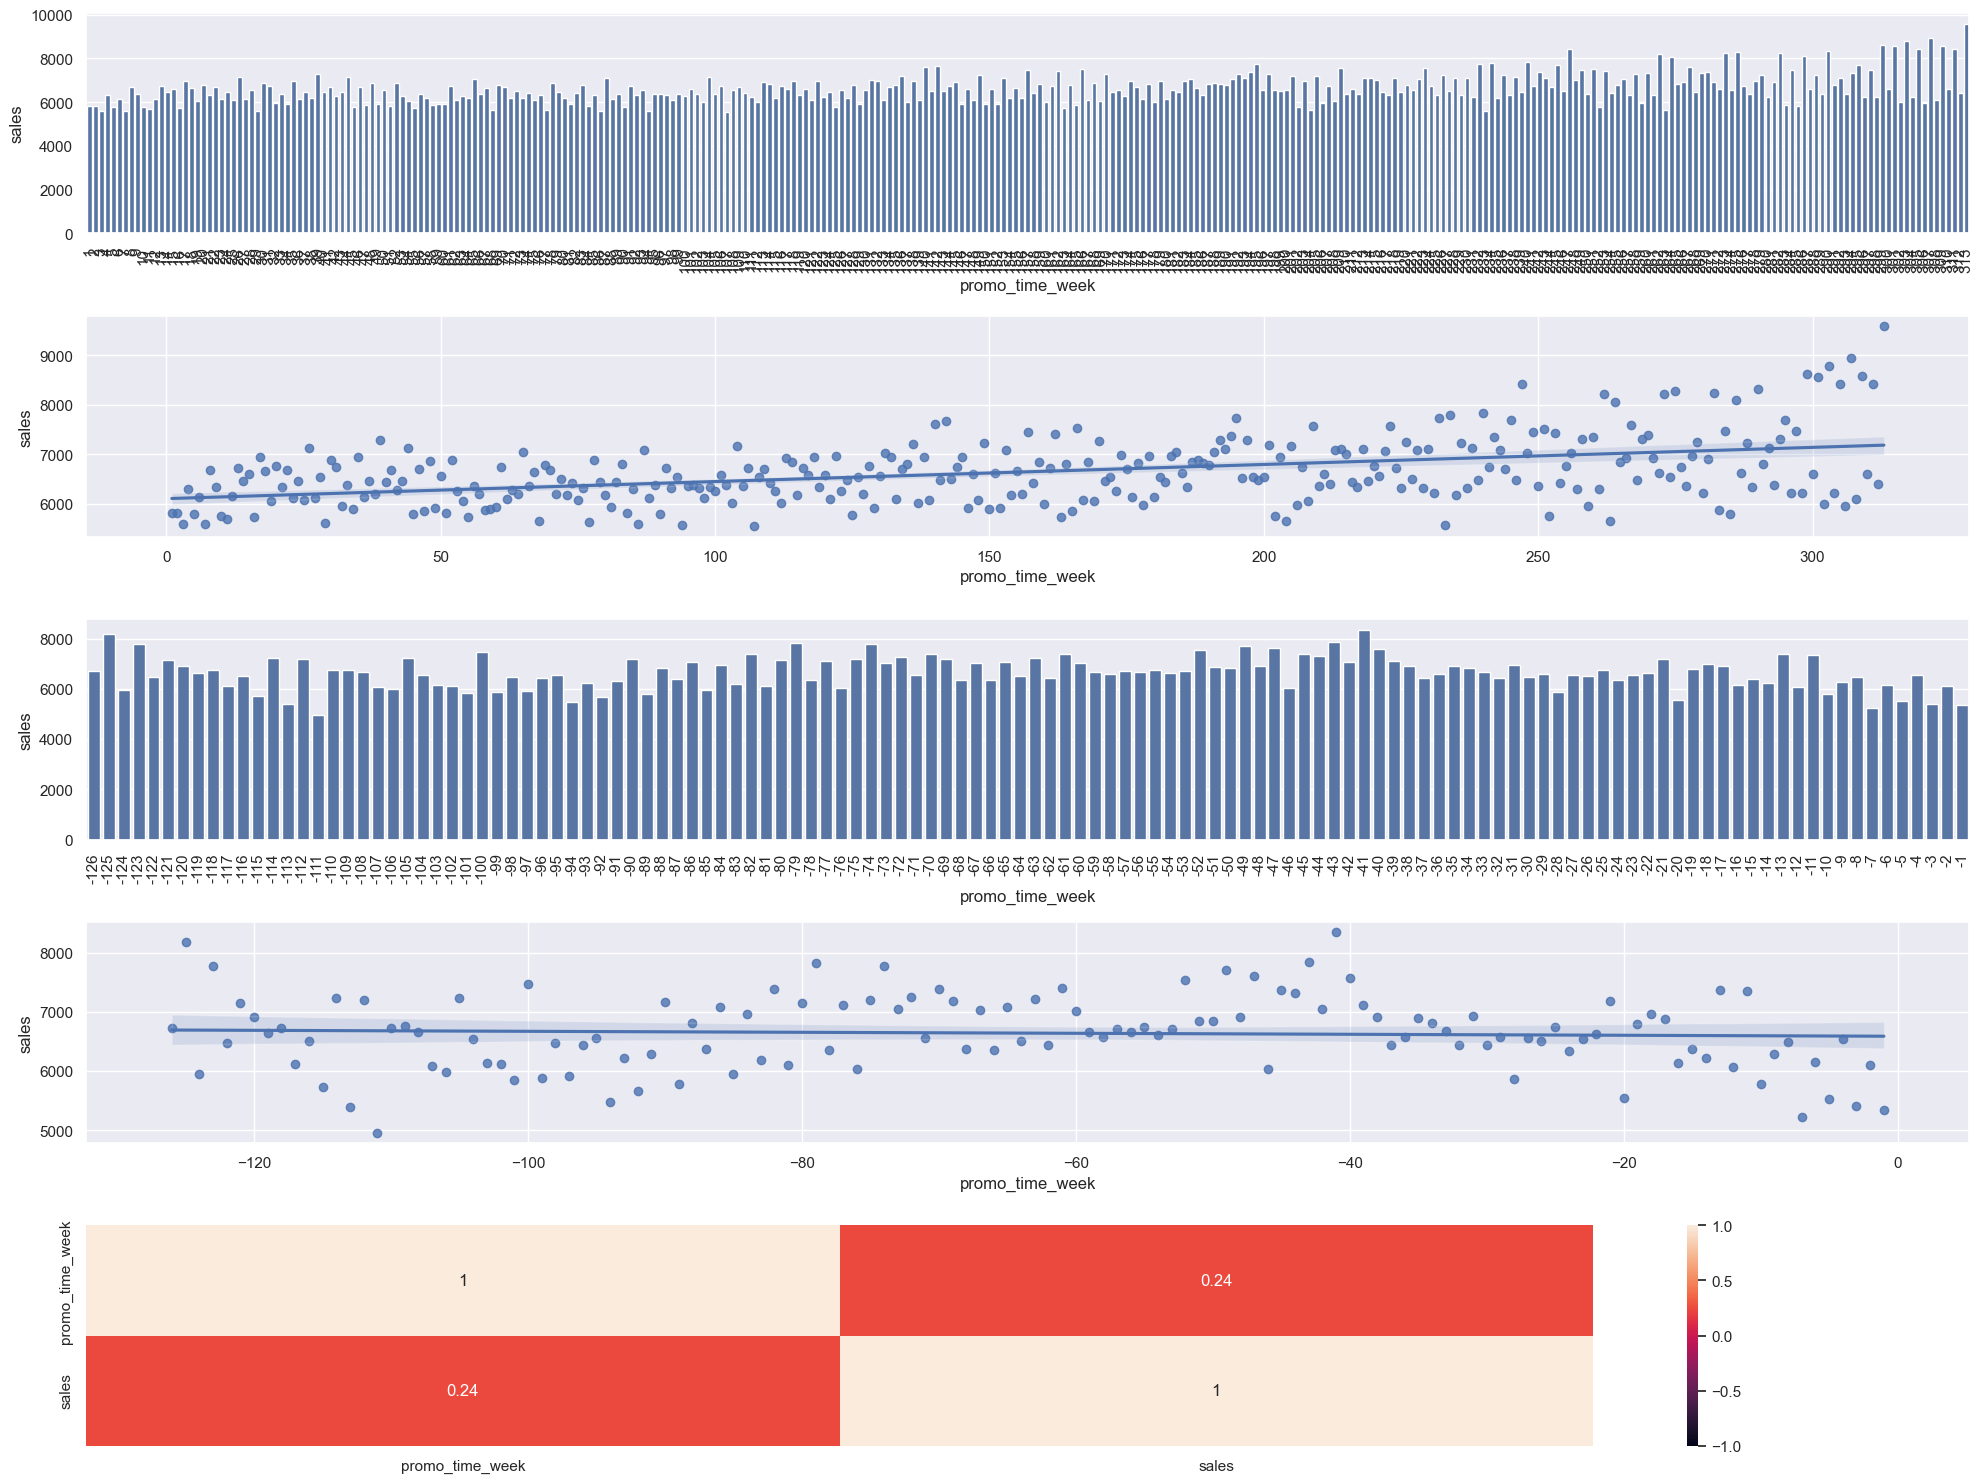

In [31]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').mean().reset_index()

plt.figure(figsize=(20, 15))
plt.subplot(5,1,1 )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );
plt.subplot( 5,1,2)
sns.regplot( x='promo_time_week', y='sales', data=aux2 );
plt.subplot( 5,1,3)
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );
plt.subplot( 5,1,4)
sns.regplot( x='promo_time_week', y='sales', data=aux3 );
plt.subplot(5,1,5)
sns.heatmap( aux1.corr( method='pearson' ), annot=True, vmin=-1, vmax=1  );
plt.tight_layout()

### H5. Lojas com mais promoções consecutivas deveriam vender mais.
Falso. Na média, lojas apenas com a primeira promoção ativa, possuem mais vendas

In [32]:
aux1 = df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2']).mean().reset_index()
aux1

,promo,promo2,sales
0,0,0,6328.187633
1,0,1,5529.566684
2,1,0,8618.452062
3,1,1,7836.672987


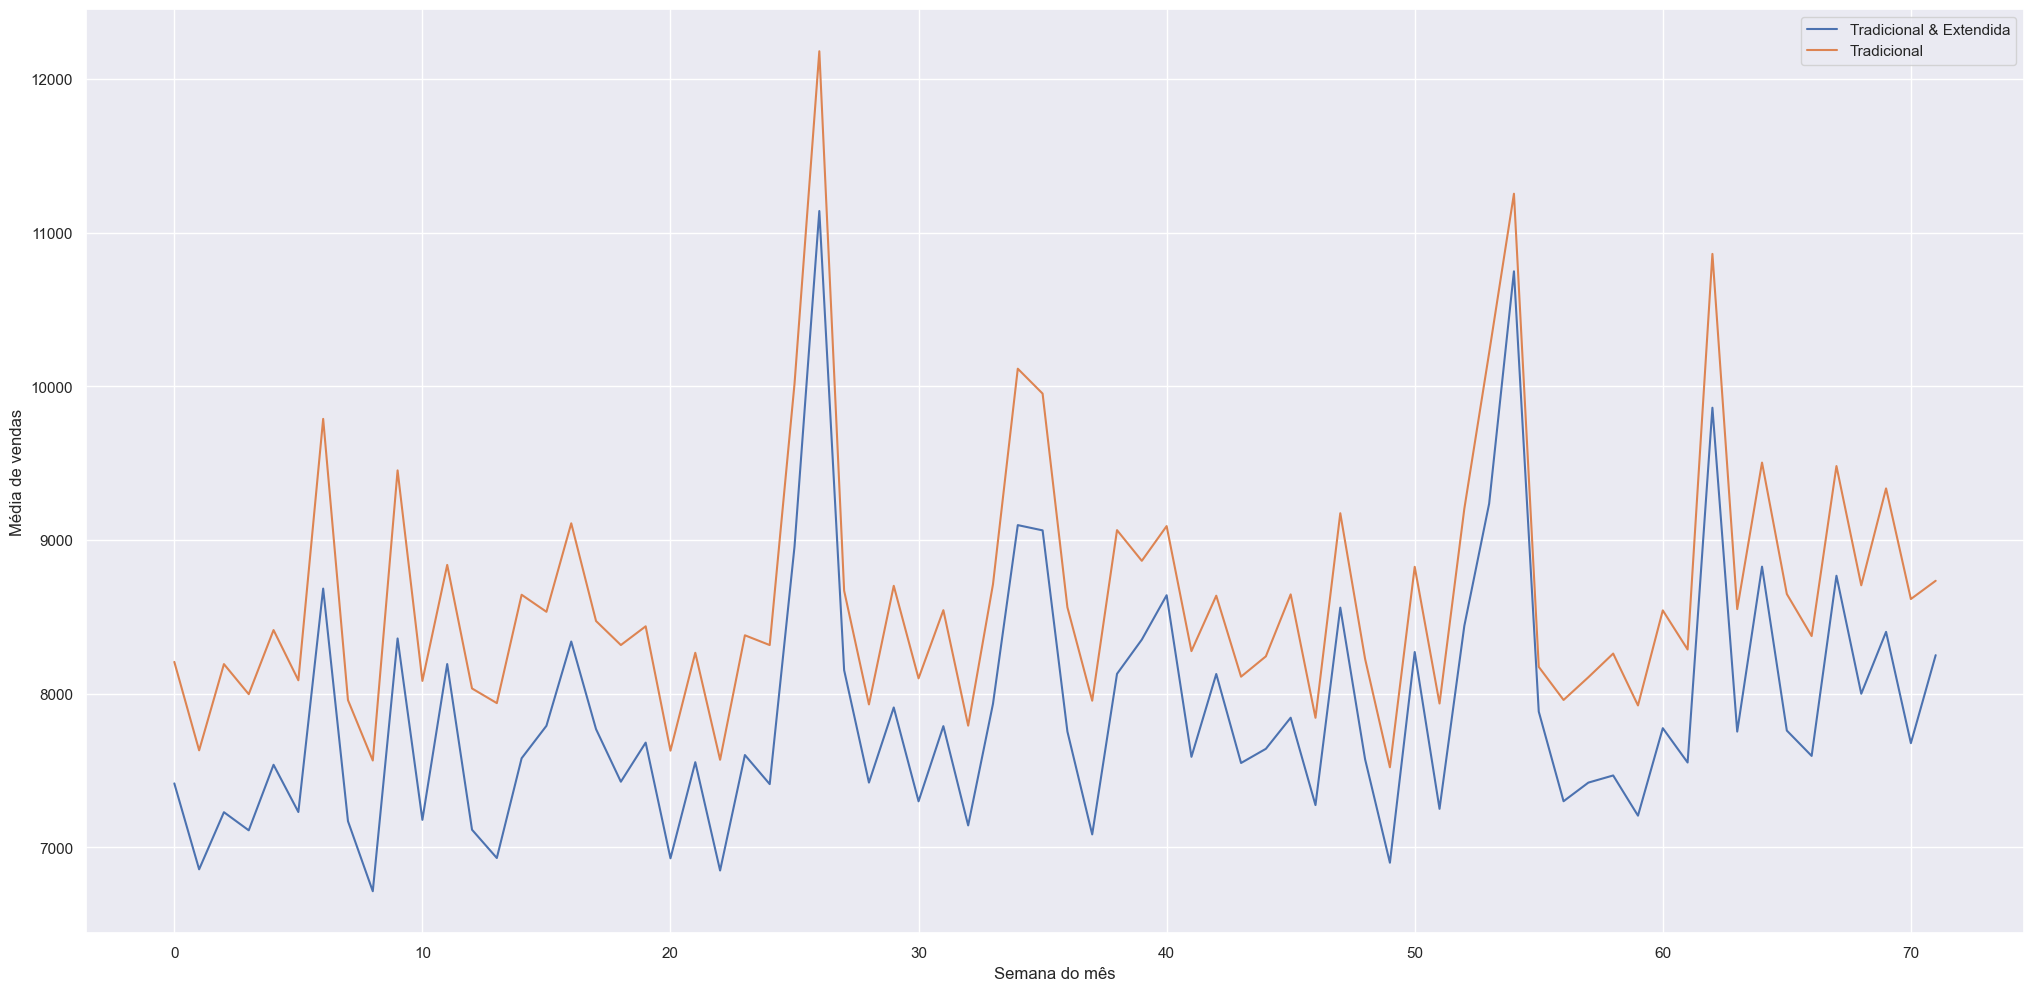

In [58]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).mean().reset_index()
ax = aux1.plot()
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).mean().reset_index()
aux2.plot( ax=ax )
ax.legend( labels=['Tradicional & Extendida', 'Tradicional']);
# Adicionar legenda para o eixo x
plt.xlabel('Semana do mês')

# Adicionar legenda para o eixo y
plt.ylabel('Média de vendas')
plt.savefig('img\\insight1.jpeg')

### H6. Lojas deveriam vender mais no feriado de natal
Verdadeiro, porém a média de vendas é um pouco maior no feriado de páscoa

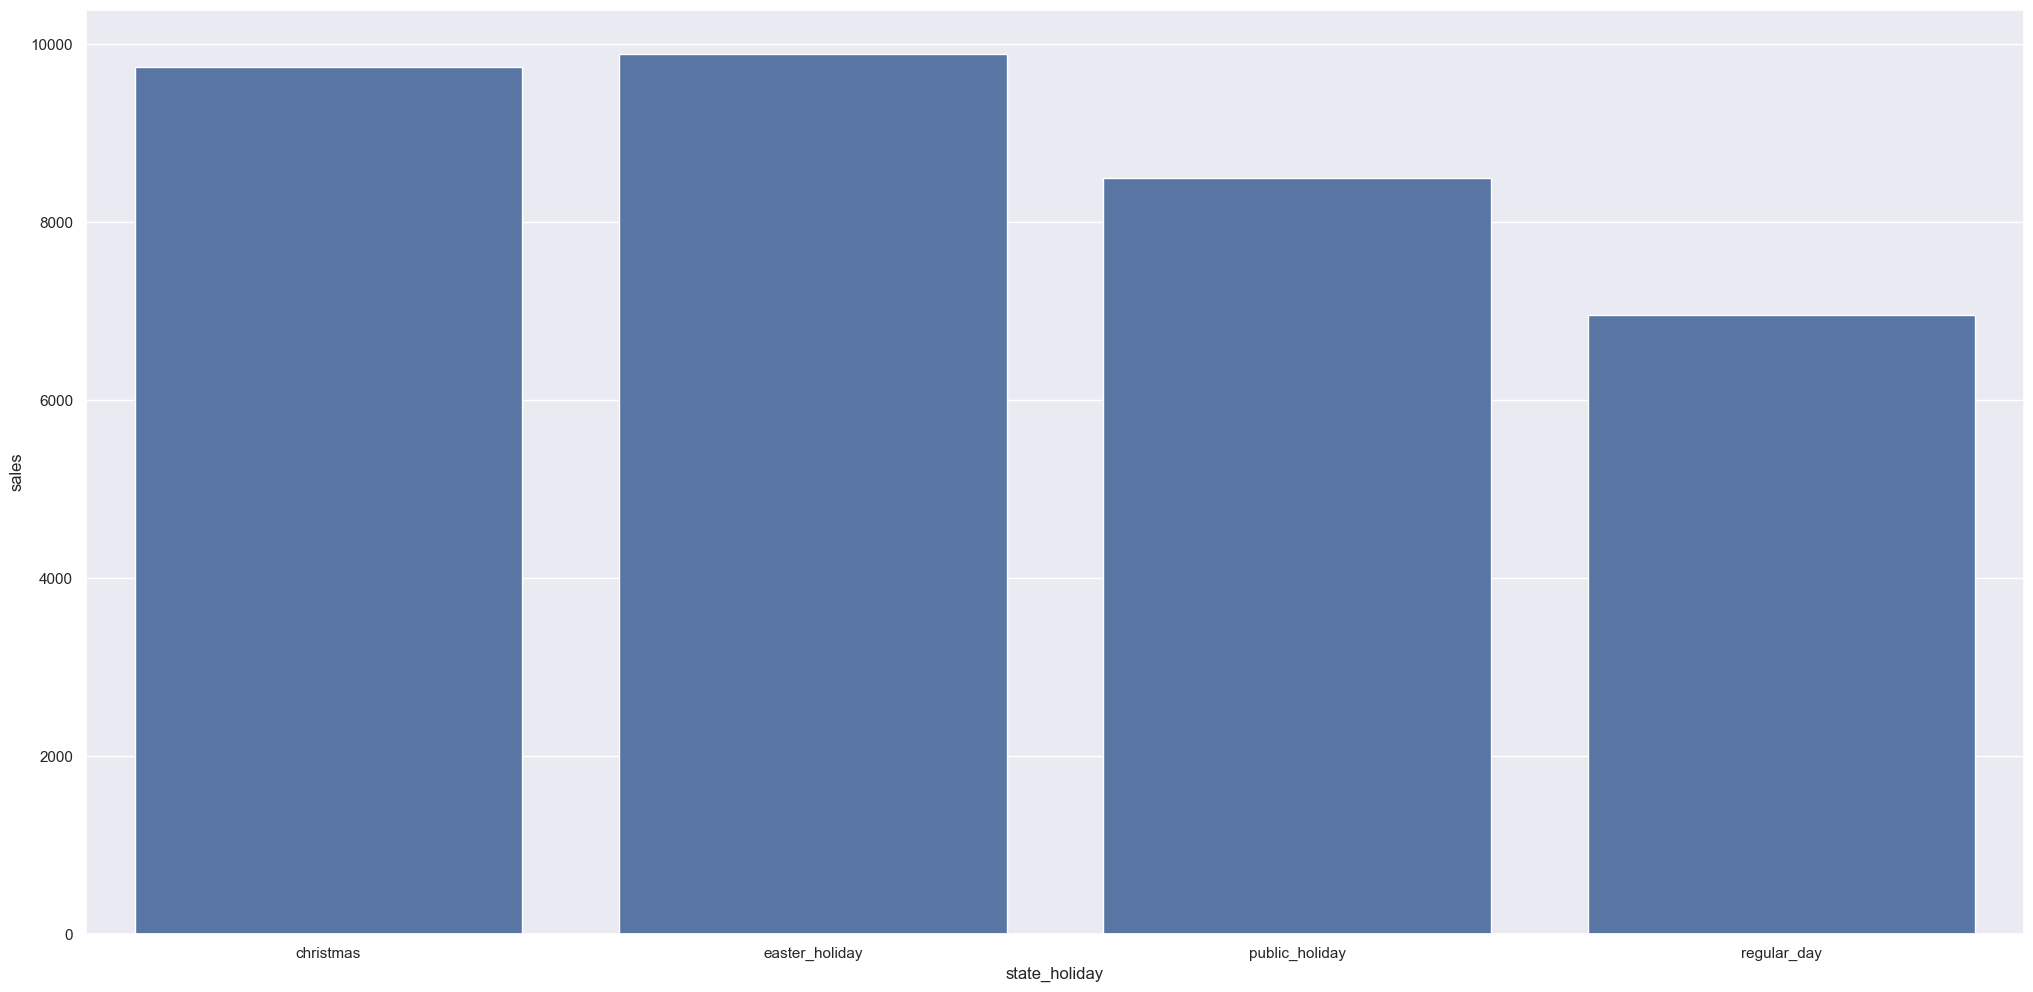

In [34]:
aux1 = df4[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );


### H7. Lojas deveriam vender mais ao longo dos anos.
Verdadeiro. Para esse análise decidimos usar como base a média também, pois o ano de 2013 tem mais registros que 2014 e 2015 ainda não está completo. Podemos observar um padrão de crescimento ao longo dos anos
O mapa de correlação indica uma alta correlação entre a variável year e a variával resposta

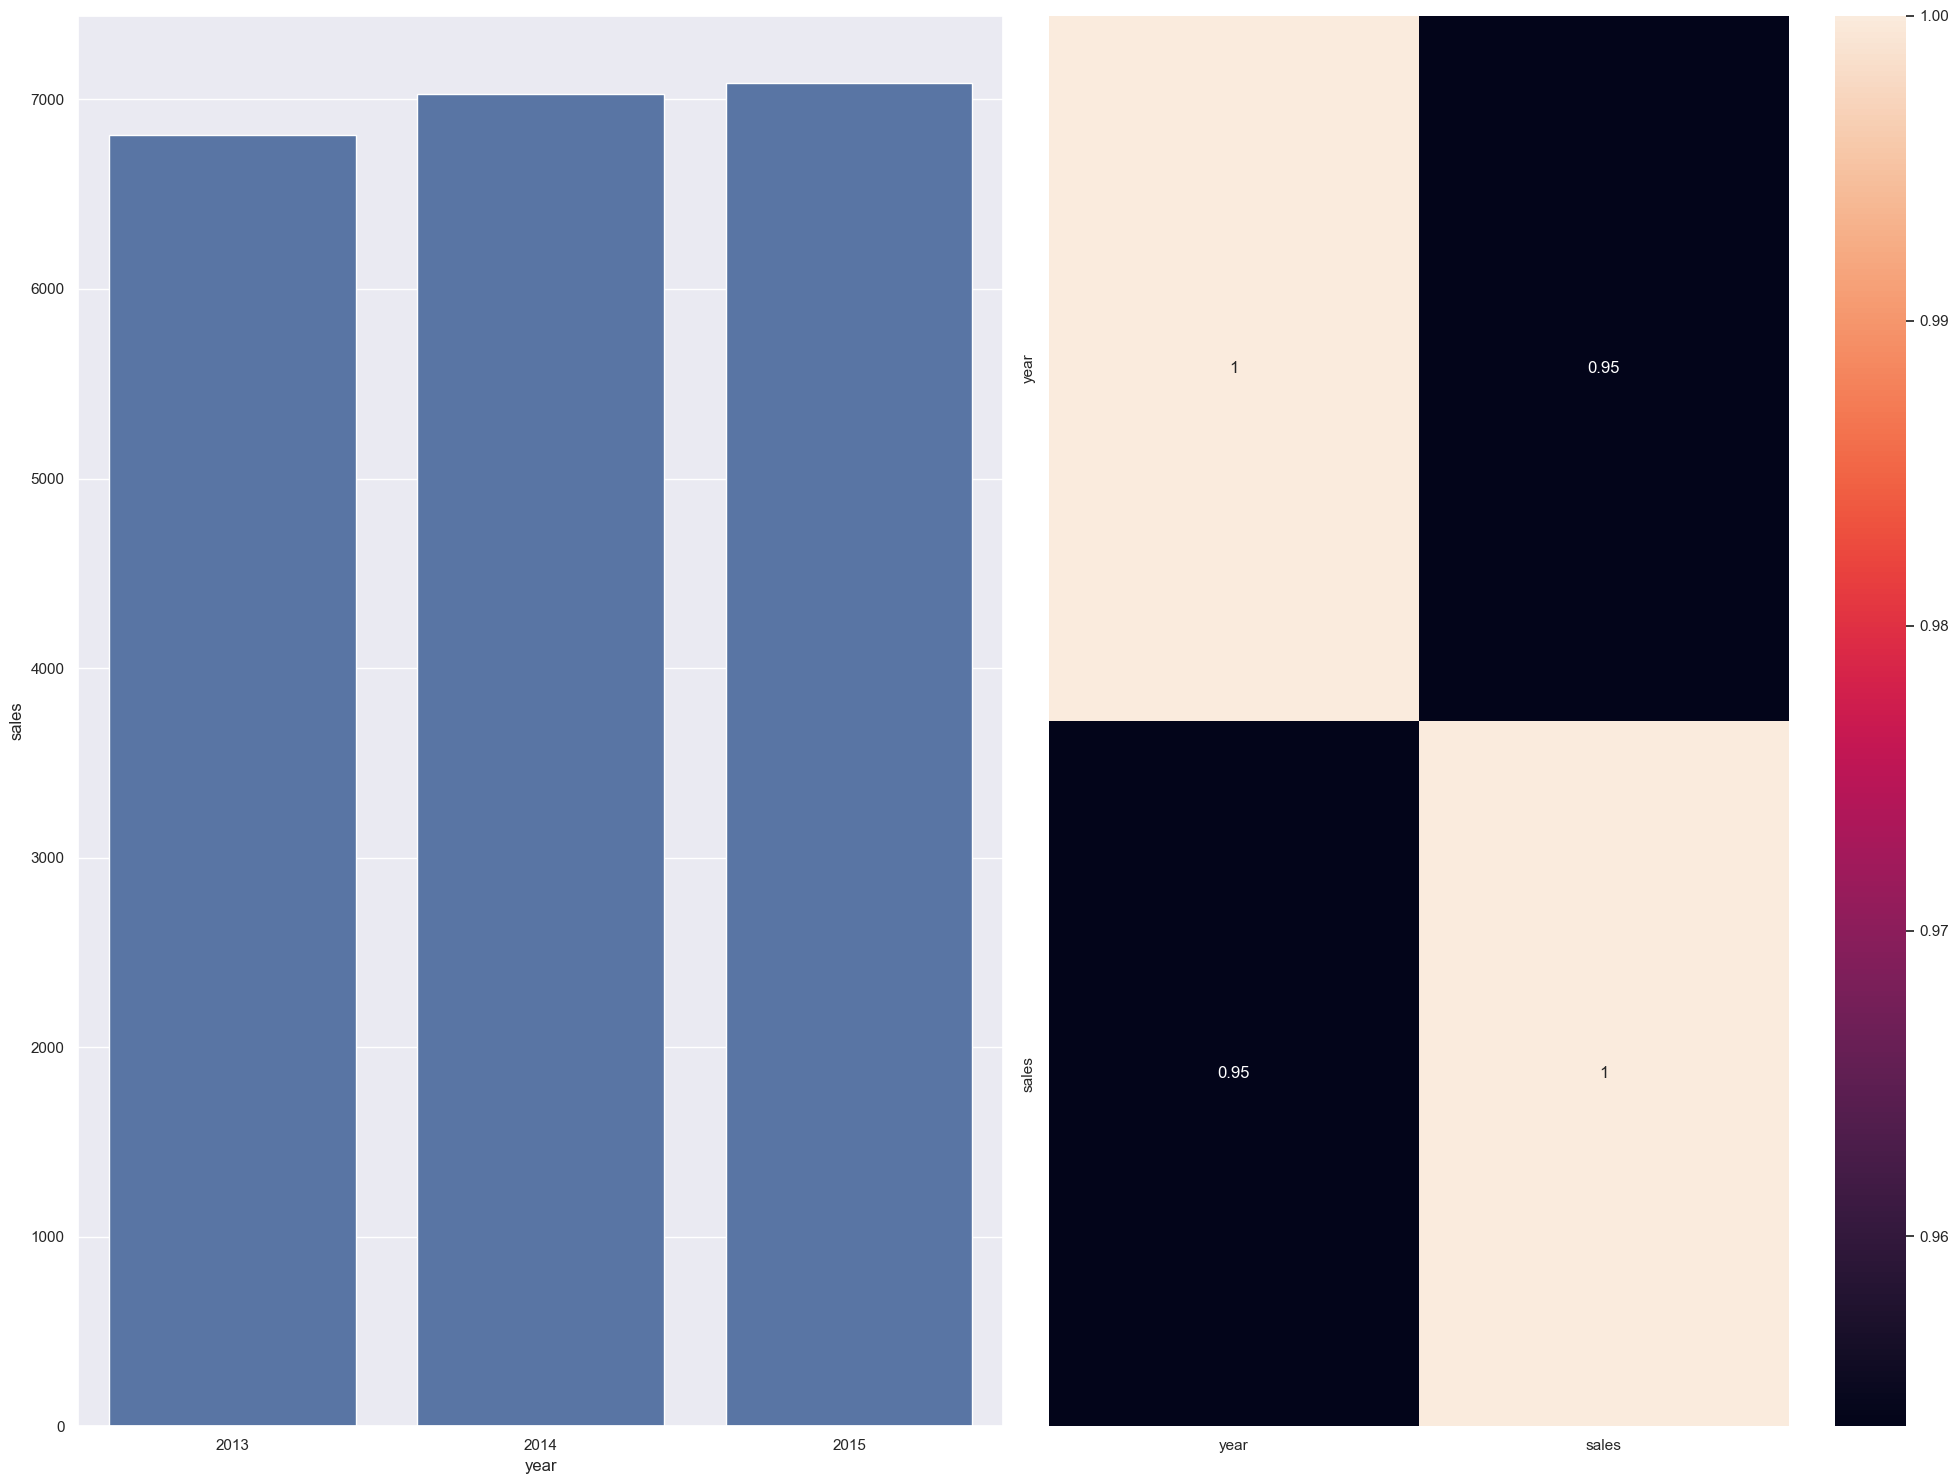

In [35]:
plt.figure(figsize=(20, 15))
aux1 = df4[['year', 'sales']].groupby('year').mean().reset_index()
plt.subplot(1,2,1)
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot(1,2,2)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
plt.tight_layout()


### H8. Lojas deveriam vender mais no segundo semestre do ano.
Verdadeira. A média de vendas no segundo semestre é maior, principalmente por conta de um aumento significativo no mês de dezembro

,semestre,média
0,1º Semestre,6879.134164
1,2º Semestre,7065.857101


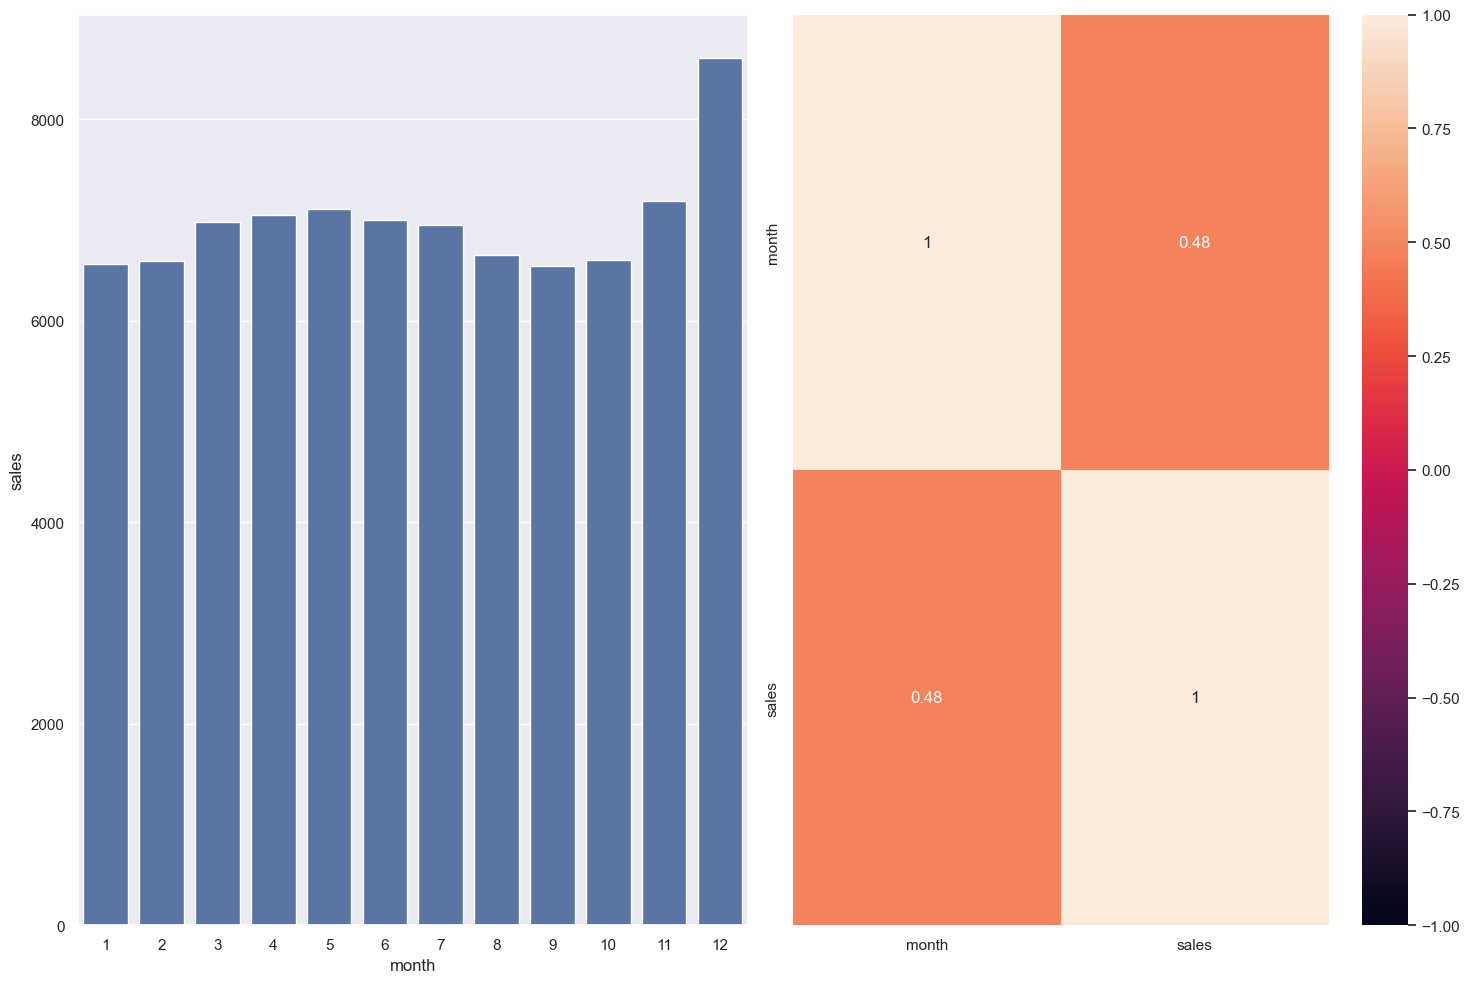

In [36]:
aux1 = df4[['month', 'sales']].groupby('month').mean().reset_index()
plt.figure(figsize=(15, 10))
plt.subplot(1,2,1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1,2,2)
sns.heatmap( aux1.corr( method='pearson' ), annot=True, vmin=-1, vmax=1  );
plt.tight_layout()

sem1 = df4.loc[df4['month'] <= 6, 'sales'].mean()
sem2 = df4.loc[ df4['month'] > 6 , 'sales'].mean()
data = {'semestre': ['1º Semestre', '2º Semestre'],
        'média': [sem1, sem2]}
df_media_semestre = pd.DataFrame(data)
df_media_semestre

### H9. Lojas deveriam vender mais depois do dia 10 de cada mês.
Falso. Se olhar a média de vendas do período depois do dia 10, ela realmente é um pouco maior. Entretando quando olhamos dia a dia, não conseguimos observar um padrão de comportamento, temos médias altas e baixas em ambos períodos. Quando olhamos a correlação ela também é baixa

,período,média
0,ate dia 10,6800.030160
1,depois dia 10,7286.921051


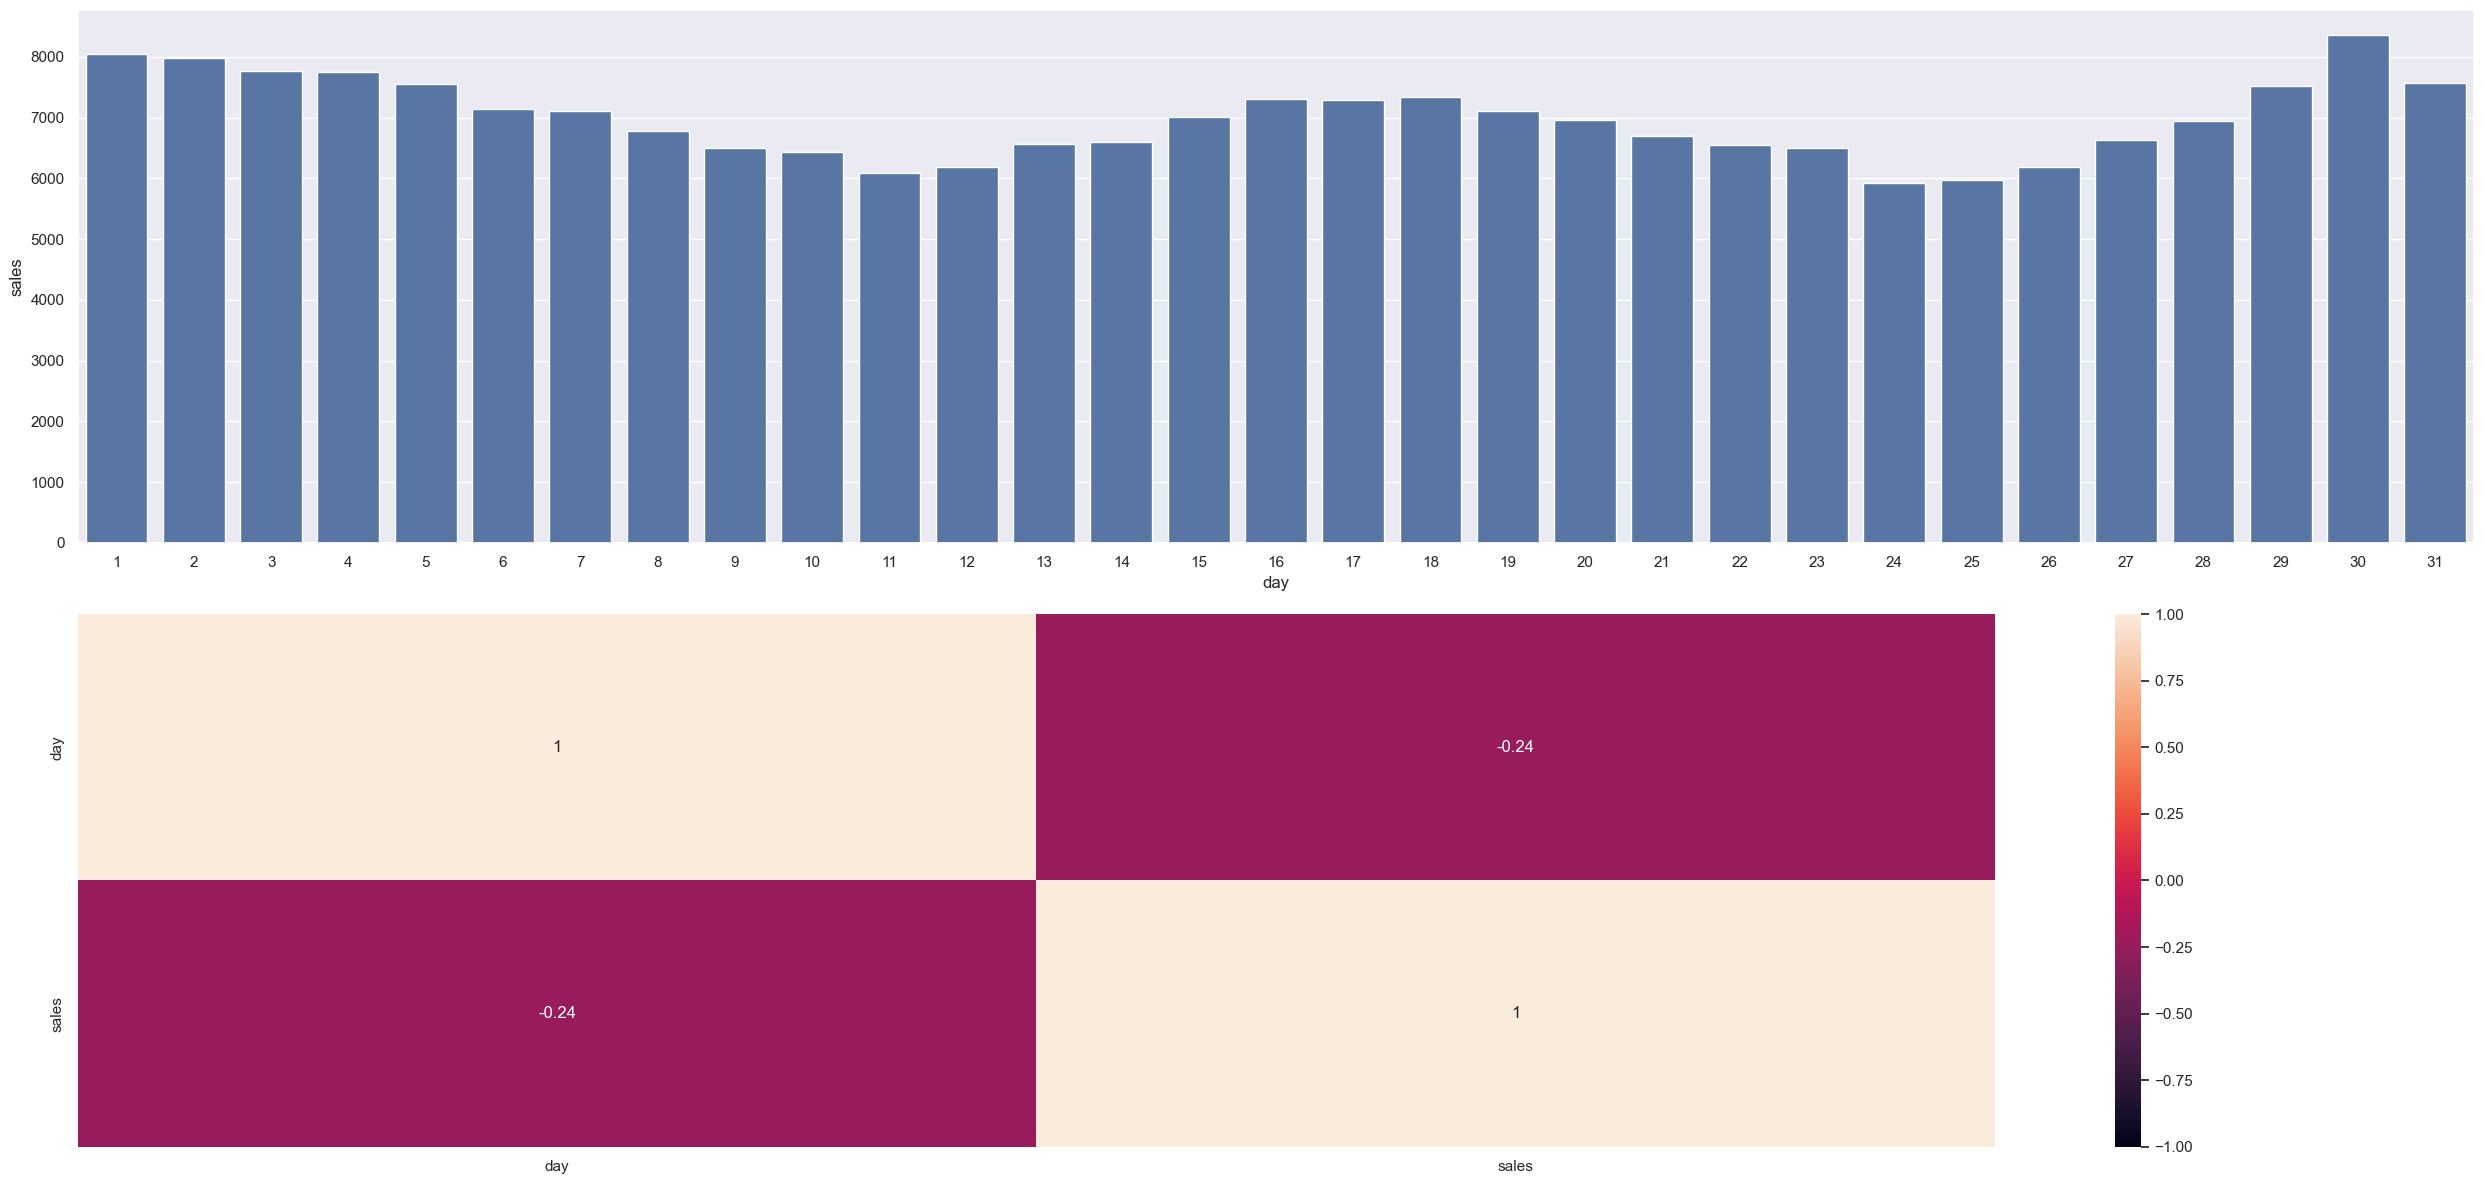

In [37]:
aux1 = df4[['day','sales']].groupby('day').mean().reset_index()
plt.subplot(2,1,1)
sns.barplot( x='day', y='sales', data=aux1 );


plt.subplot(2,1,2)
sns.heatmap( aux1.corr( method='pearson' ), annot=True, vmin=-1, vmax=1 );
plt.tight_layout()


aux = df4.loc[df4['day'] > 10, 'sales'].mean()
aux1 = df4.loc[df4['day'] <= 10, 'sales'].mean()
data = {'período': ['ate dia 10', 'depois dia 10'],
        'média': [aux, aux1]}
df_media_dias = pd.DataFrame(data)
df_media_dias

### H10. Lojas deveriam vender menos aos finais de semana.
Falso. Considerando o dia 1 como domingo e o dia 7 como sábado. Lojas vendem mais no final de semana (são as duas médias mais altas).
Quando avaliamos a correlação ela é baixa, indicando que a variável não tem muita ligação com a variável resposta

,período,média
0,final de semana,8216.467906
1,dia de semana,6702.938870


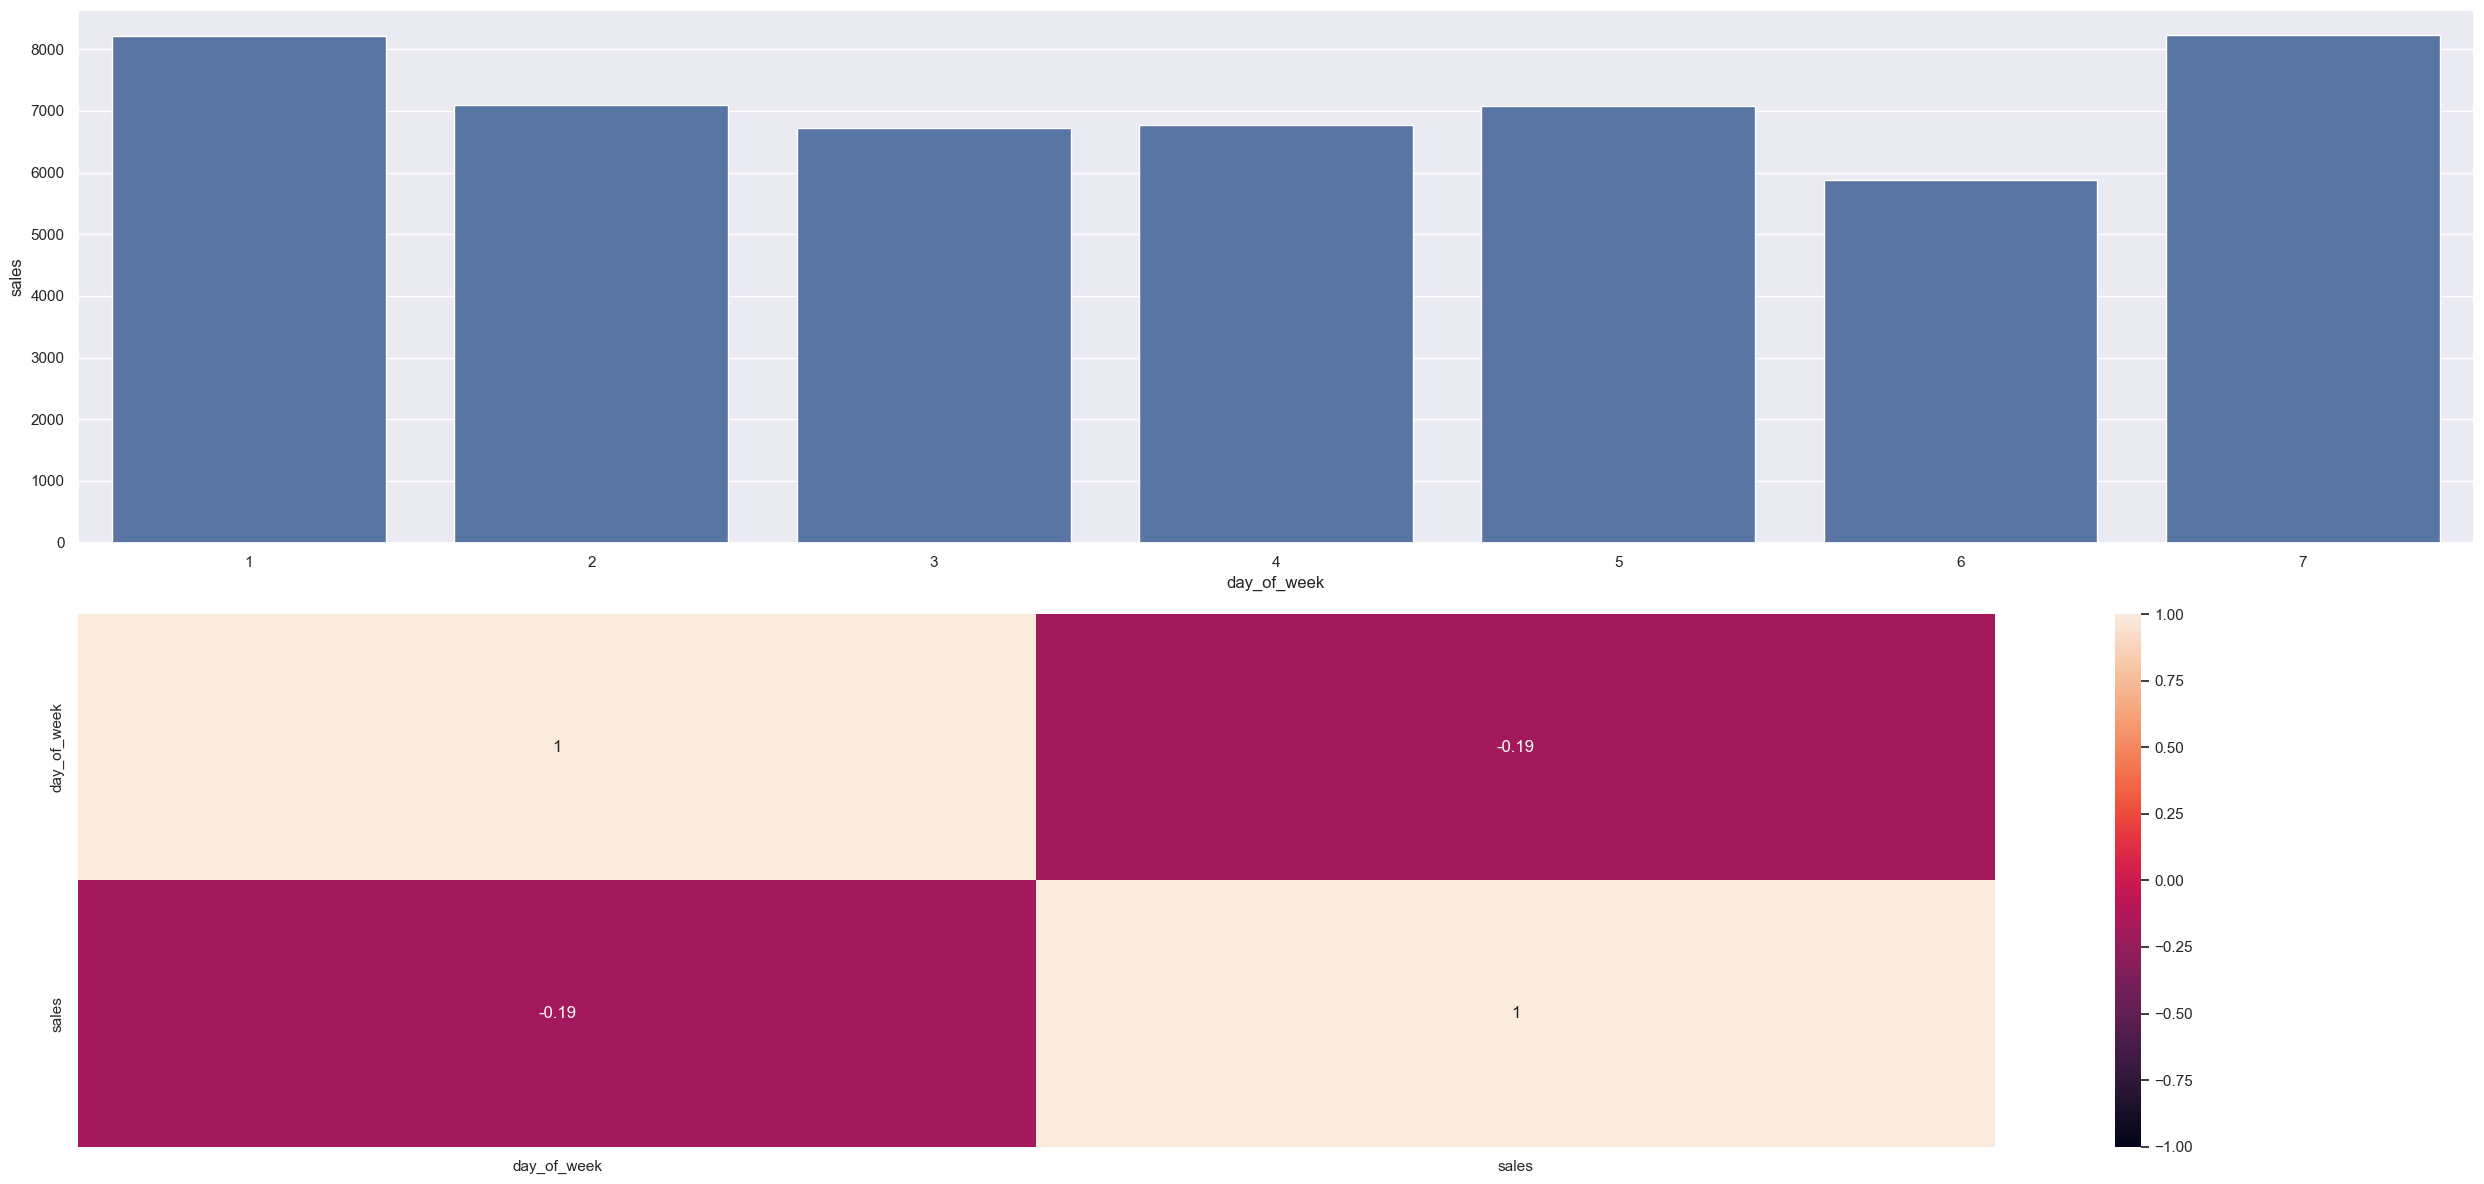

In [38]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').mean().reset_index()
plt.subplot(2,1,1)
sns.barplot( x='day_of_week', y='sales', data=aux1 );


plt.subplot(2,1,2)
sns.heatmap( aux1.corr( method='pearson' ), annot=True, vmin=-1, vmax=1   );
plt.tight_layout()

aux = df4.loc[(df4['day_of_week'] == 1) | (df4['day_of_week'] == 7) , 'sales'].mean()
aux1 = df4.loc[(df4['day_of_week'] != 1) & (df4['day_of_week'] != 7) , 'sales'].mean()
data = {'período': ['final de semana', 'dia de semana'],
        'média': [aux, aux1]}
df_media = pd.DataFrame(data)
df_media


### H11. Lojas deveriam vender menos durante os feriados escolares.
Falso.  Com base  na média, o valor de vendas é maior um pouco maior em dias de feriados escolares. Quando olhamos para os feriados mês a mês. nota-se que todos os meses, os dias de feriados possuem uma maior média, com exceção apenas de dezembro

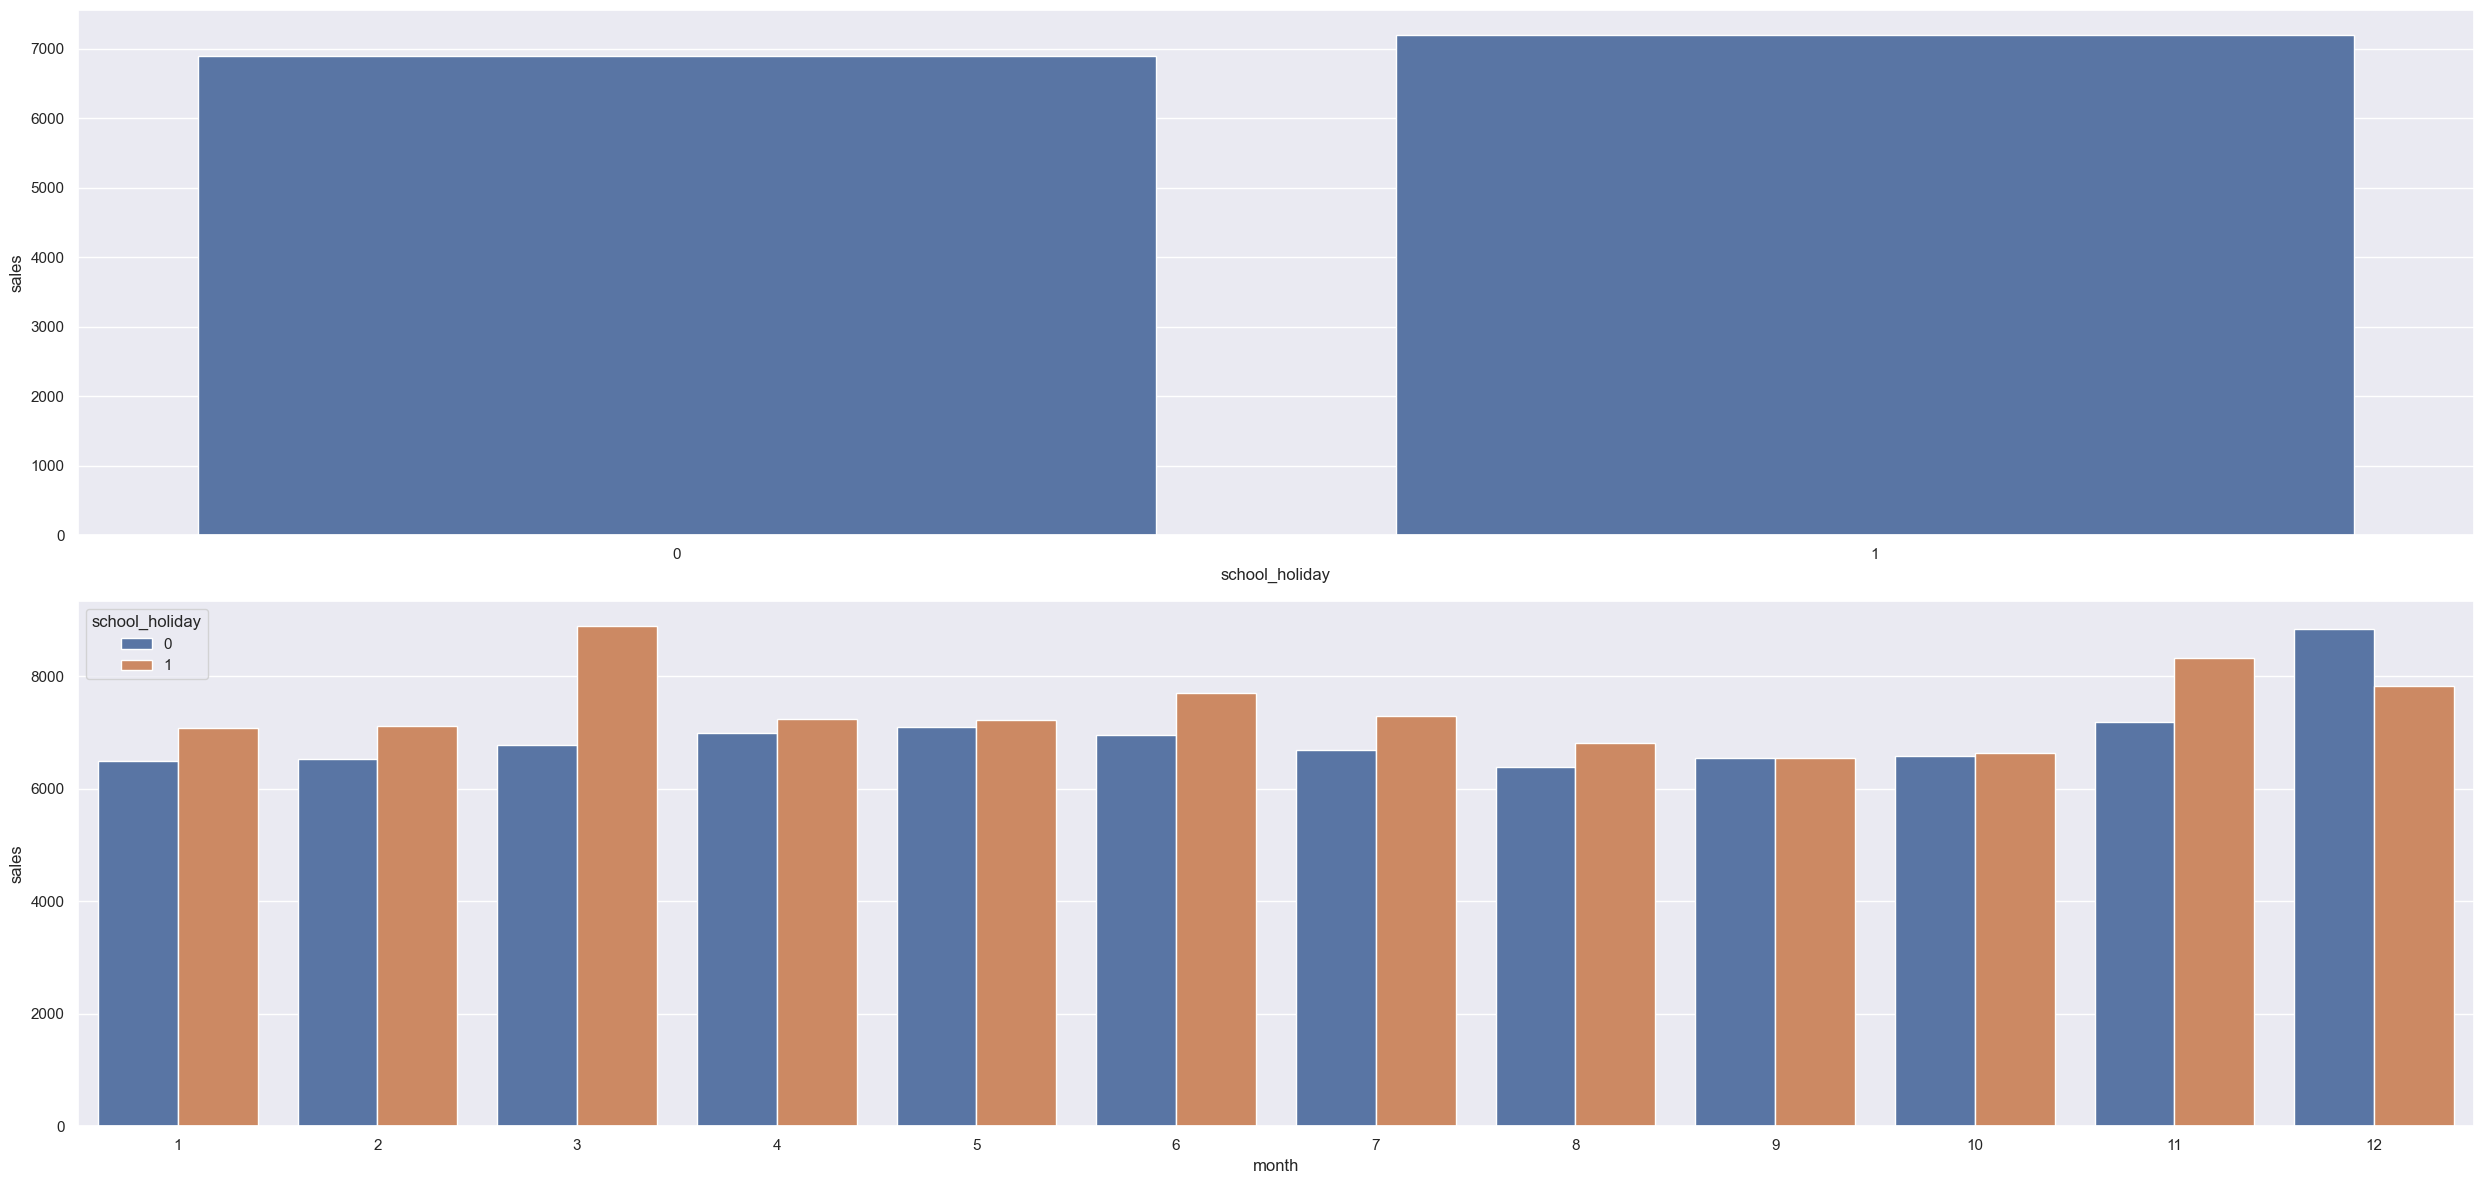

In [39]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).mean().reset_index()

plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)

plt.tight_layout()

### 4.2.1. Resumo das Hipoteses

In [40]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'], 
      ['H1', 'Verdadeira', 'Alta'], 
      ['H2', 'Falsa', 'Baixa'],
['H3', 'Falsa', 'Alta'],
['H4', 'Verdadeira', 'Media'],
['H5', 'Falsa', 'Baixa'],
['H6', 'Verdadeira', 'Media'],
['H7', 'Verdadeira', 'Alta'],
['H8', 'Verdadeira', 'Alta'],
['H9', 'Falsa', 'Baixa'],
['H10', 'Falsa', 'Baixa'],
['H11', 'Falsa', 'Alta'],
]
print( tabulate( tab, headers='firstrow' ))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Verdadeira   Alta
H2           Falsa        Baixa
H3           Falsa        Alta
H4           Verdadeira   Media
H5           Falsa        Baixa
H6           Verdadeira   Media
H7           Verdadeira   Alta
H8           Verdadeira   Alta
H9           Falsa        Baixa
H10          Falsa        Baixa
H11          Falsa        Alta


## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

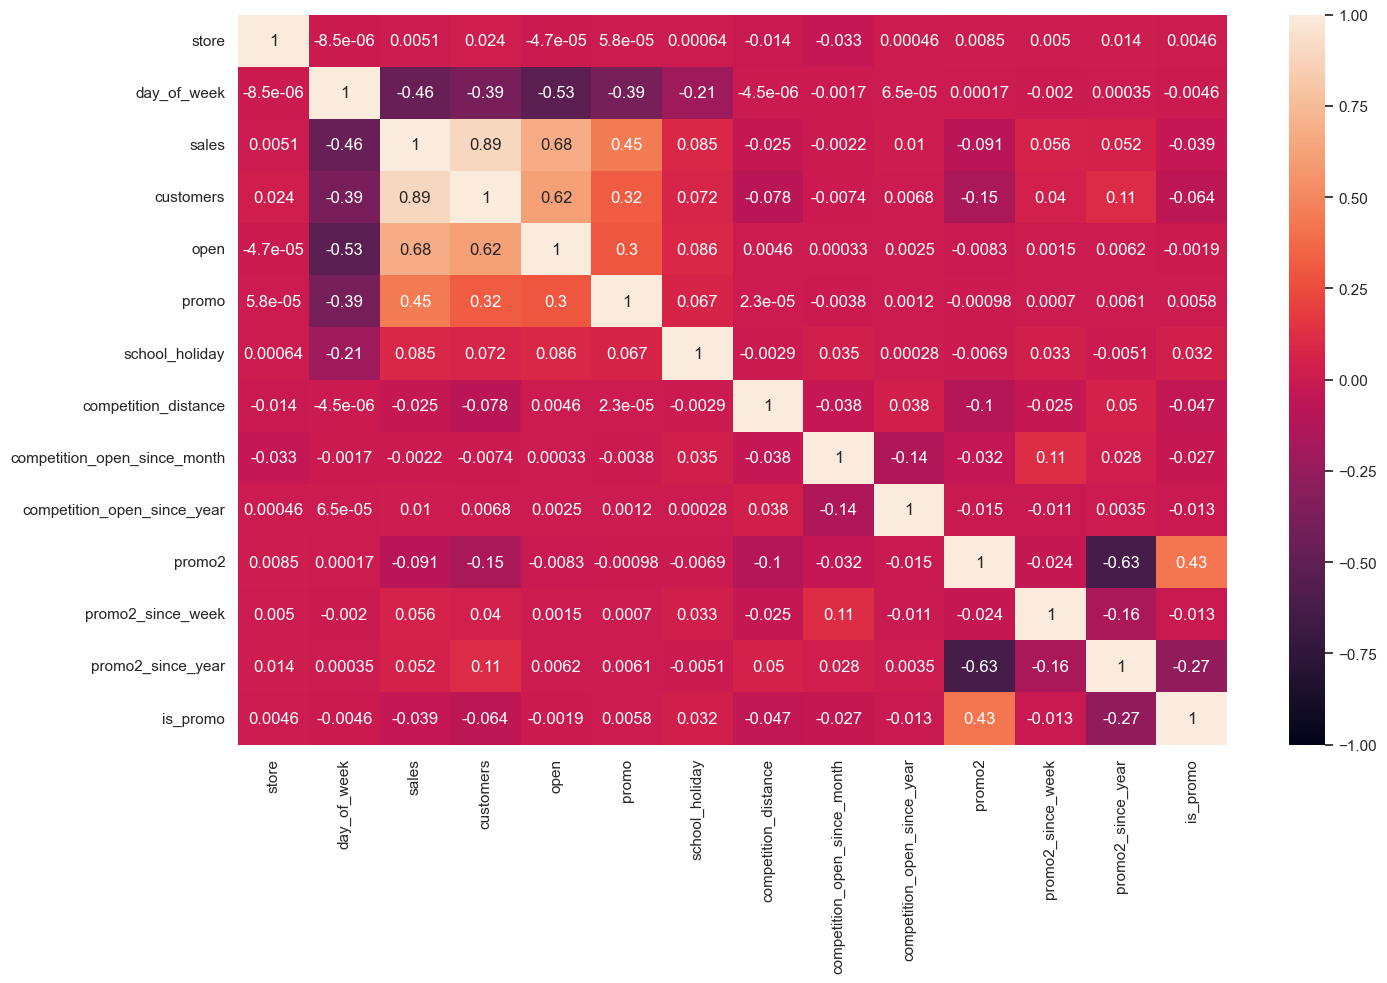

In [41]:
correlation = num_attributes.corr( method='pearson' )
plt.figure(figsize=(15, 10))
sns.heatmap( correlation, annot=True, vmin=-1, vmax=1  );
plt.tight_layout()

### 4.3.2. Categorical Attributes

<Axes: >

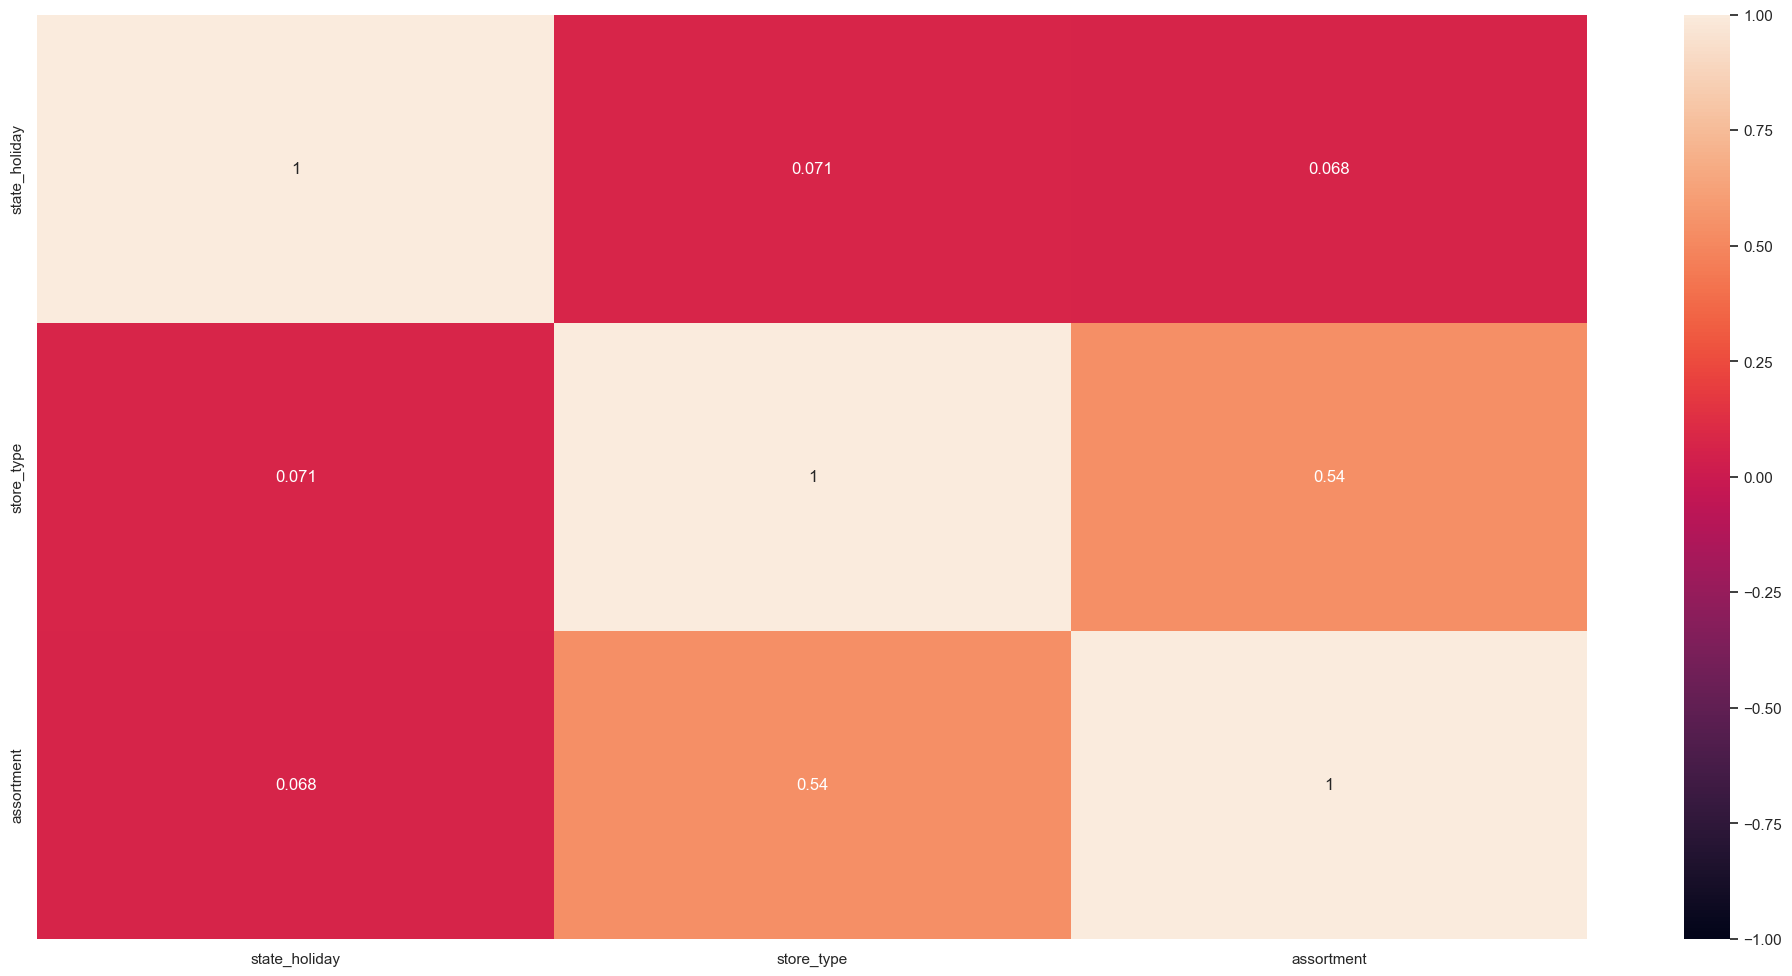

In [42]:
# only categorical data
a = df4.select_dtypes( include='object' )
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )
# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],'store_type': [a4, a5, a6],'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True, vmin=-1, vmax=1  )

# 5.0. PASSO 05 - DATA PREPARATION

In [43]:
df5 = df4.copy()

## 5.1. Normalizacao
O dataset não possui nenhuma variável com uma distribuição gaussiana o que não torna viável o uso dessa reescala

## 5.2. Rescaling

In [44]:
rs = RobustScaler()
mms = MinMaxScaler()
# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter\\competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameter\\competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'parameter\\promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameter\\year_scaler.pkl', 'wb') )

## 5.3. Transformacao

### 5.3.1. Encoding

In [45]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extended': 2, 'extra': 3} 
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation

In [46]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3. Nature Transformation

In [47]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. *np.pi/7 ) ) )
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )
# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2.* np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2.* np.pi/52 ) ) )

# 6.0 PASSO 06 - FEATURE SELECTION

In [48]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [49]:
df6.head(5)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,False,False,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,False,False,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,False,False,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,2,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,False,False,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,False,False,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [50]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since','competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [51]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']
# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']
print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )
print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [52]:
##training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

##define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

##define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )

### 6.2.1. Best Features from Boruta

In [53]:
cols_selected = boruta.support_.tolist()

## best features
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )

NameError: name 'boruta' is not defined

## 6.3. Manual Feature Selection

In [ ]:
cols_selected_boruta = ['store', 'promo','store_type','assortment','competition_distance',
                         'competition_open_since_month','competition_open_since_year','promo2',
                         'promo2_since_week','promo2_since_year','competition_time_month','promo_time_week',
                         'day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos',
                         'week_of_year_sin','week_of_year_cos','year','school_holiday']
# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [ ]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()
# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename(columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']
# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1(yhat_baseline ) )
baseline_result


## 7.2. Linear Regression Model

In [ ]:
# model
lr = LinearRegression().fit( x_train, y_train )
# prediction
yhat_lr = lr.predict( x_test )
# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr ) )
lr_result

### 7.2.1. Linear Regression Model - Cross Validation

In [ ]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr,verbose=False )
lr_result_cv

## 7.3. Linear Regression Regularized Model - Lasso

In [ ]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )
# prediction
yhat_lrr = lrr.predict( x_test )
# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result


### 7.3.1. Lasso - Cross Validation

In [ ]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

## 7.4. Random Forest Regressor

In [ ]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit(x_train, y_train )
# prediction
yhat_rf = rf.predict( x_test )
# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf ) )
rf_result

### 7.4.1. Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf,verbose=True )
rf_result_cv

## 7.5. XGBoost Regressor

In [ ]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror' ).fit( x_train, y_train )
# prediction
yhat_xgb = model_xgb.predict( x_test )
# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb ) )
xgb_result

### 7.5.1. XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor',model_xgb, verbose=True )
xgb_result_cv

## 7.6. Compare Model’s Performance

### 7.6.1. Single Performance

In [ ]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result,rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

### 7.6.2. Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv,xgb_result_cv] )
modelling_result_cv

# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [ ]:
param = {
 'n_estimators': [1500, 1700, 2400, 2800, 3000],
 'eta': [0.01, 0.03],
 'max_depth': [3, 5, 9],
 'subsample': [0.1, 0.5, 0.7],
 'colsample_bytree': [0.3, 0.7, 0.9],
 'min_child_weight': [3, 8, 15]
 }

MAX_EVAL = 5

In [ ]:
#final_result = pd.DataFrame()

#for i in range( MAX_EVAL ):
    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
 #   print( hp )
    #
    # # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#    n_estimators=hp['n_estimators'],
#    eta=hp['eta'],
#    max_depth=hp['max_depth'],
#    subsample=hp['subsample'],
#    colsample_bytree=hp['colsample_bytree'],
#    min_child_weight=hp['min_child_weight'] )

    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb,verbose=True )
#    final_result = pd.concat( [final_result, result] )

#final_result

## 8.2. Final Model

In [ ]:
param_tuned = {
'n_estimators': 1500,
'eta': 0.03,
'max_depth': 9,
'subsample': 0.7,
'colsample_bytree': 0.3,
'min_child_weight': 8
}

In [ ]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
n_estimators=param_tuned['n_estimators'],
eta=param_tuned['eta'],
max_depth=param_tuned['max_depth'],
subsample=param_tuned['subsample'],colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )
# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb_tuned ) )
xgb_result_tuned


# 9.0. PASSO 09 - TRADUCAO E INTERPRETACAO DO ERRO

In [ ]:
df9 = X_test[ cols_selected_boruta_full ]
df9 = df9.copy()
# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [ ]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()
# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: 
                    mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: 
                    mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})
# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )
# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']
# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]


In [ ]:
df92.sort_values( 'MAPE', ascending=True ).head(20)

In [ ]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 9.2. Total Performance

In [ ]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: 
        np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

## 9.3. Machine Learning Performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

In [ ]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot(x=df9['predictions'], y=df9['error'])


# 10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTION

In [ ]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open('C:\\Users\\michele\\projetos\\repos\\ds_em_producao\\model\\model_rossmann.pkl', 'wb'))

## 10.1. Rossmann Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossmann( object ):
    def __init__( self ):
        self.home_path='C:\\Users\\michele\\projetos\\repos\\ds_em_producao'
        self.competition_distance_scaler = pickle.load( open( self.home_path + '\\parameter\\competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + '\\parameter\\competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler = pickle.load( open( self.home_path + '\\parameter\\promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler = pickle.load( open( self.home_path + '\\parameter\\year_scaler.pkl', 'rb') )
        self.store_type_scaler = pickle.load( open( self.home_path + '\\parameter\\store_type_scaler.pkl', 'rb') )
    def data_cleaning( self, df1 ):
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',
        'StoreType', 'Assortment', 'CompetitionDistance','CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']
        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )
        # rename
        df1.columns = cols_new
        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )
        ## 1.5. Fillout NA
        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )
        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: 
                                        x['date'].month if math.isnan( x['competition_open_since_month'] ) else 
                                        x['competition_open_since_month'], axis=1 )
        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( 
            x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )
        #promo2_since_week
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( 
            x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
        #promo2_since_year
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( 
            x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )
        #promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6:'Jun', 
                     7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df1['promo_interval'].fillna(0, inplace=True )
        df1['month_map'] = df1['date'].dt.month.map( month_map )
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x:0 if 
                        x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )
        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        return df1
    def feature_engineering( self, df2 ):
        # year
        df2['year'] = df2['date'].dt.year
        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day
        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear
        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )
        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                            month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply(
                                            lambda x: x.days ).astype( int )
        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(
                                    x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )
        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )
        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x:'public_holiday' 
                            if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )
        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]
        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        return df2
    def data_preparation( self, df5 ):
        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( 
                                    df5[['competition_distance']].values )
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( 
                                        df5[['competition_time_month']].values )
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values )
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )
        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )
        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'] )
        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )
        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin(x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos(x * ( 2. * np.pi/52 ) ) )
        cols_selected = ['store', 'promo','store_type','assortment','competition_distance',
                         'competition_open_since_month','competition_open_since_year','promo2',
                         'promo2_since_week','promo2_since_year','competition_time_month','promo_time_week',
                         'day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos',
                         'week_of_year_sin','week_of_year_cos','year','school_holiday']
        return df5[ cols_selected ]
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from api.rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( 'C:\\Users\\michele\\projetos\\repos\\ds_em_producao\\model\\model_rossmann.pkl', 'rb') )
# initialize API
app = Flask( __name__ )
@app.route( '/rossmann/predict', methods=['POST'] )

def rossmann_predict():
    test_json = request.get_json()
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            # Instantiate Rossmann class
            pipeline = Rossmann()
            # data cleaning
            df1 = pipeline.data_cleaning( test_raw )
            # feature engineering
            df2 = pipeline.feature_engineering( df1 )
            # data preparation
            df3 = pipeline.data_preparation( df2 )
            # prediction
            df_response = pipeline.get_prediction( model, test_raw, df3 )
            return df_response
    else:
        return Reponse( '{}', status=200, mimetype='application\\json' )
if __name__ == '__main__':
    app.run( '0.0.0.0' )

## 10.3. API Tester

In [ ]:
# loading test dataset
df10 = pd.read_csv( 'C:\\Users\\michele\\projetos\\repos\\ds_em_producao\\data\\test.csv' )

In [ ]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )
# choose store for prediction
df_test = df_test[df_test['Store'].isin( [1, 42, 22] )]
# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [ ]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
# API Call
#url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'https://rossmann-api-oy3p.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [ ]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()
for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
    d2.loc[i, 'store'],
    d2.loc[i, 'prediction'] ) )

In [ ]:
d1.head()